# 시계열 예측 - clogging


In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## clogging data

```
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
```

In [2]:
import os
import mglearn

df = pd.read_csv(
    os.path.join(mglearn.datasets.DATA_PATH, "constant_trial.csv") )

# 예제를 위해 몇개의 열만 선택합니다
#df = df[['IR', 'FlowHt', 'Const', 'Var', 'Base', 'MixS75','MixS50','MixS25']]
df = df[['IR', 'FlowHt', 'Base', 'MixS75','MixS50','MixS25']]
display(df.head())


,IR,FlowHt,Base,MixS75,MixS50,MixS25
0,1.0000,0.0000,1,0,0,0
1,0.9995,0.1798,1,0,0,0
2,0.9985,0.5389,1,0,0,0
3,0.9970,1.0757,1,0,0,0
4,0.9950,1.7884,1,0,0,0


```
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
Oneencoder = OneHotEncoder(categorical_features=[0])
#df[:,4] = encoder.fit_transform(df[:,4])

df[:,4] = Oneencoder.fit_transform(df[:,4])
```

In [3]:
# 검사 및 정리하기

### 데이터 분할

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
#train_df = df[0:int(n*0.7)]
train_df = df[0:int(n*0.5)].copy()
#train2_df = df[int(n*0.25):int(n*0.5)].copy()
test_df = df[int(n*0.5):int(n*0.75)].copy()
val_df = df[int(n*0.75):].copy()

num_features = df.shape[1]
num_features


train_df.describe()

train_mean = train_df.mean()
train_std = train_df.std()

In [4]:
# ## 데이터 정규화

train_df.iloc[:,:2] = (train_df.iloc[:,:2] - train_mean.iloc[:2]) / train_std.iloc[:2]
val_df.iloc[:,:2]  = (val_df.iloc[:,:2]  - train_mean[:2]) / train_std[:2]
test_df.iloc[:,:2]  = (test_df.iloc[:,:2]  - train_mean[:2]) / train_std[:2]

train_df.describe()
val_df.describe()


,IR,FlowHt,Base,MixS75,MixS50,MixS25
count,5.800000e+01,58.000000,58.0,58.0,58.0,58.0
mean,-4.134624e-16,-0.853230,0.0,0.0,0.0,1.0
std,1.004376e+00,0.067829,0.0,0.0,0.0,0.0
min,-2.169563e+00,-1.030756,0.0,0.0,0.0,1.0
25%,-7.442049e-01,-0.882278,0.0,0.0,0.0,1.0
50%,2.780219e-01,-0.840215,0.0,0.0,0.0,1.0
75%,8.971169e-01,-0.806375,0.0,0.0,0.0,1.0
max,1.113080e+00,-0.754539,0.0,0.0,0.0,1.0


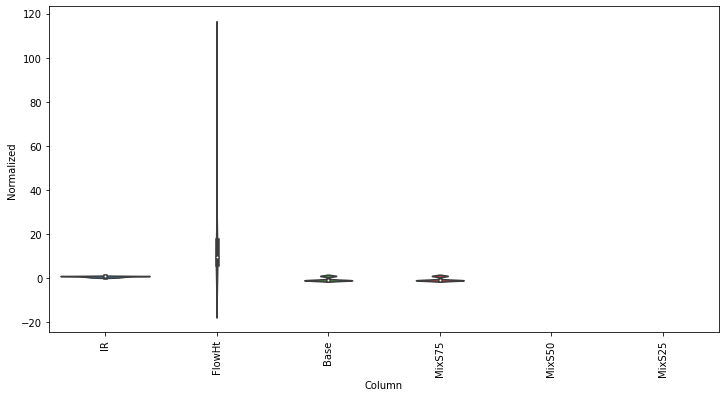

In [5]:
train_mean = train_df.mean()
train_std = train_df.std()
#df_std = (df - train_mean) / train_std
df_mean = df.mean()
df_std = df.std()
df_std_s = (df - train_mean) / train_std
df_std_m = df_std_s.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std_m)
_ = ax.set_xticklabels(df.keys(), rotation=90)


### remove nan after standard normalization
```
#drop feature including NaN
df1 = df_std_s.dropna(axis = 1)
df1.info()

corr_matrix = df1.corr()
corr_matrix["FlowHt"].sort_values(ascending=False)
```

In [6]:
df_pop = df.copy()
IR =  df_pop.pop('IR')

(1.041325, 0.0)

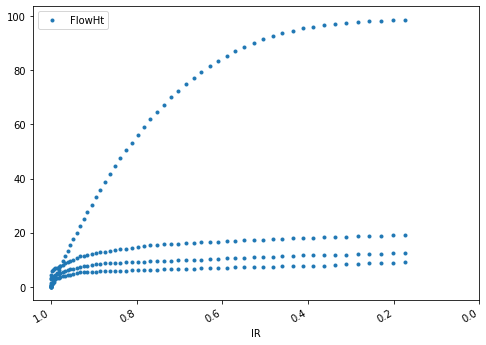

In [7]:
plot_cols = ['FlowHt']
plot_features = df[plot_cols]
plot_features.index = IR
_ = plot_features.plot( linestyle = 'None', marker = '.', subplots=True)
plt.xlim([plt.xlim()[1], 0])

(1.041325, 0.0)

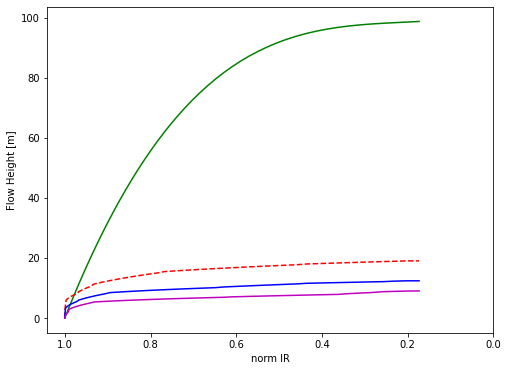

In [8]:
plt.plot(df.iloc[0:58,0], df.iloc[0:58,1], 'g-'
         , df.iloc[58:116,0], df.iloc[58:116,1],'r--'
         ,df.iloc[116:174,0], df.iloc[116:174,1],'b-'
         ,df.iloc[174:232,0], df.iloc[174:232,1], 'm-')
plt.xlabel('norm IR')
plt.ylabel('Flow Height [m]')
#plt.axis('equal')
#plt.axis('square')
plt.xlim([plt.xlim()[1], 0])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])

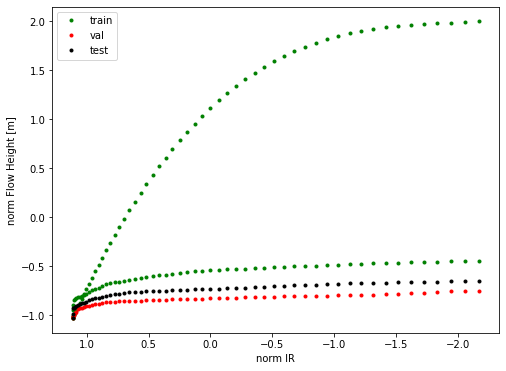

In [9]:
plt.plot(train_df['IR'], train_df['FlowHt'], 'g.', label='train')
plt.plot(         val_df['IR'], val_df['FlowHt'], 'r.', label='val')
plt.plot(          test_df['IR'], test_df['FlowHt'], 'k.', label='test')
plt.xlabel('norm IR')
plt.ylabel('norm Flow Height [m]')
plt.xlim([plt.xlim()[1], plt.xlim()[0]])
plt.ylim([plt.ylim()[0], plt.ylim()[1]])
plt.legend(loc='best')


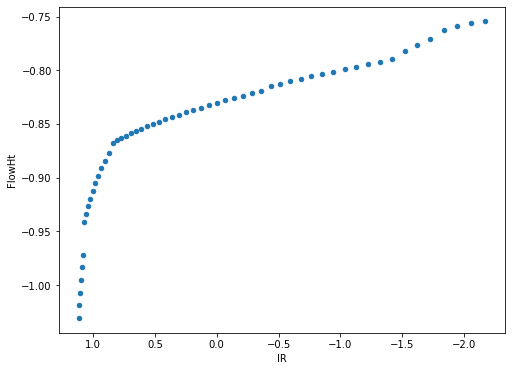

In [10]:
ax = val_df.plot(kind="scatter", x="IR", y="FlowHt")

ax.invert_xaxis()

## 데이터 창 작업
### WindowGrerator Class
## WinGen()

In [11]:
class WinGen():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'
    ])


def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  lab = features[:, self.labels_slice, 0:2]

  #global lab
#  lab = tf.identity(labels)
#  lab = tf.stack([lab[:, :, 0:2]])
#  lab = lab[0,:,:,:]

  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

#  lab.set_shape([None, self.label_width, None])
  return inputs, labels, lab

WinGen.split_window = split_window


def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
#      shuffle=False, #default
      shuffle=True,
      batch_size=16,)
  ds = ds.map(self.split_window)
  # ds = ds.map(lambda input, lable : x[:, self.input_slice, :], ......)

  return ds

WinGen.make_dataset = make_dataset


'''
#def time(self, feature) :
#    lab = ds_o.map(lambda x : x[0:8, self.labels_slice, 0:4])
#    ds_lab = ds_o.map(self.split_window)
#    labels = ds_o.map(lambda x : x[:, self.labels_slice, :])

  #global lab
  #  lab = tf.identity(labels)
#    return lab

#WinGen.time = time

#def split_window_lab(self, features):
#  inputs_t = features[:, self.input_slice, :]
#  labels_t = features[:, self.labels_slice, :]

#  lab = tf.identity(labels_t)
#  lab = tf.stack([lab[:, :, 0:2]])
#  lab = lab[0,:,:,:]

#  if self.label_columns is not None:
#    labels_t = tf.stack(
#        [labels_t[:, :, self.column_indices[name]] for name in self.label_columns],
#        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
#  inputs_t.set_shape([None, self.input_width, None])
#  labels_t.set_shape([None, self.label_width, None])
#  lab.set_shape([None, self.label_width, None])

#  return inputs_t,labels_t, lab
#  return lab

WinGen.split_window_lab = split_window_lab
'''

@property
def train(self):
  return self.make_dataset(self.train_df)
#  return self.make_dataset(self.train_df_s)

@property
def val(self):
  return self.make_dataset(self.val_df)
#  return self.make_dataset(self.val_df_s)

@property
def test(self):
  return self.make_dataset(self.test_df)
#  return self.make_dataset(self.test_df_s)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result


WinGen.train = train
WinGen.val = val
WinGen.test = test
WinGen.example = example
'''
@property
def train_time (self):
    return self.time(self.train_df)
@property
def val_time (self):
    return self.time(self.val_df)
@property
def test_time (self):
    return self.time(self.test_df)


WinGen.train_time = train_time
WinGen.val_time = val_time
WinGen.test_time = test_time
'''
#------------------------------------------------------------------
wide_window = WinGen(
    input_width=8, label_width=8, shift=1,
    label_columns=['FlowHt'])

wide_window

dataset_test = wide_window.train

for batch in dataset_test :
    inputs, targets,lab = batch

## WindowGenerator() Original

In [12]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'
    ])


def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]

  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  return inputs, labels

WindowGenerator.split_window = split_window


def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
#      shuffle=False, #default
      shuffle=True,
      batch_size=16,)
  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset
'''
def time(self, data) :
    data = np.array(data, dtype=np.float32)
    ds_lab = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False, #default
#      shuffle=True, #default
      batch_size=16,)
#
#    for batch in ds:
#        labels_1 = batch[:, self.labels_slice, :]
#        labels_t = tf.stack( [labels_1[:, :, 0:2]])
#    labels_t = labels_t[0,:,:,:]
    ds_lab = ds_lab.map(self.split_window_lab)

    return ds_lab

WindowGenerator.time = time

def split_window_lab(self, features):
#  inputs_t = features[:, self.input_slice, :]
  labels_t = features[:, self.labels_slice, :]

  lab = tf.identity(labels_t)
  lab = tf.stack([lab[:, :, 0:2]])
  lab = lab[0,:,:,:]

#  if self.label_columns is not None:
#    labels_t = tf.stack(
#        [labels_t[:, :, self.column_indices[name]] for name in self.label_columns],
#        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
#  inputs_t.set_shape([None, self.input_width, None])
#  labels_t.set_shape([None, self.label_width, None])
  lab.set_shape([None, self.label_width, None])

#  return inputs_t,labels_t, lab
  return lab

WindowGenerator.split_window_lab = split_window_lab
'''

@property
def train(self):
  return self.make_dataset(self.train_df)
#  return self.make_dataset(self.train_df_s)

@property
def val(self):
  return self.make_dataset(self.val_df)
#  return self.make_dataset(self.val_df_s)

@property
def test(self):
  return self.make_dataset(self.test_df)
#  return self.make_dataset(self.test_df_s)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

'''
@property
def train_time (self):
    return self.time(self.train_df)
@property
def val_time (self):
    return self.time(self.val_df)
@property
def test_time (self):
    return self.time(self.test_df)


WindowGenerator.train_time = train_time
WindowGenerator.val_time = val_time
WindowGenerator.test_time = test_time
'''

'\n@property\ndef train_time (self):\n    return self.time(self.train_df)\n@property\ndef val_time (self):\n    return self.time(self.val_df)\n@property\ndef test_time (self):\n    return self.time(self.test_df)\n\n\nWindowGenerator.train_time = train_time\nWindowGenerator.val_time = val_time\nWindowGenerator.test_time = test_time\n'

In [13]:
wide_window = WindowGenerator(
    input_width=8, label_width=8, shift=1,
    label_columns=['FlowHt'])

wide_window
#print(wide_window)


dataset_test = wide_window.train
for batch in dataset_test :
    inputs, targets = batch

In [14]:
n=0
for example_inputs, example_labels in wide_window.train.take(2):
#for example_inputs, example_labels in wide_window.train:
  print(n)
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
#  print(f'Inputs shape (batch, time, features): {example_inputs[31][23][18]}')
#  print(f'Inputs shape (batch, time, features): {example_inputs[0][0:2][:]}')
#  print(f'Inputs shape (batch, time, features): {example_inputs}')
  n+=1

0
Inputs shape (batch, time, features): (16, 8, 6)
Labels shape (batch, time, features): (16, 8, 1)
1
Inputs shape (batch, time, features): (16, 8, 6)
Labels shape (batch, time, features): (16, 8, 1)


# fn(plot) : original
- one batch example
- time indeces plot
- example 3 signal dataset

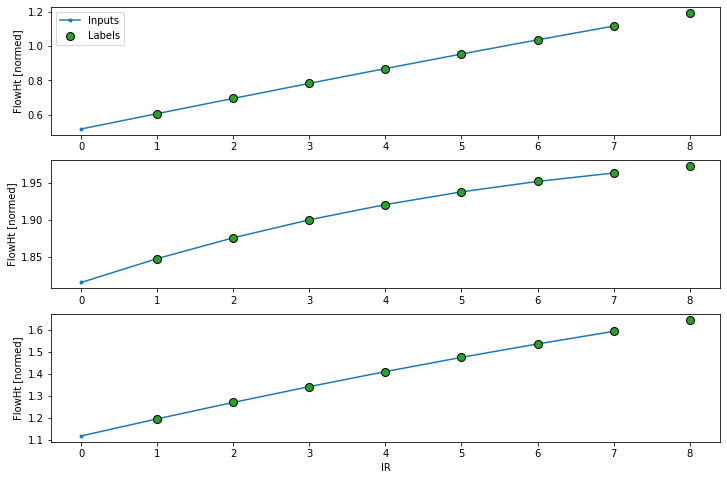

In [15]:
def plot(self, model=None, plot_col='FlowHt', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
#  for n in range(3, 32):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('IR')

WindowGenerator.plot = plot

wide_window.plot()



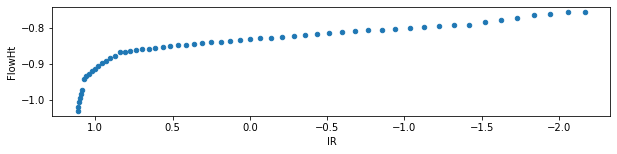

In [16]:
ax = val_df.plot(kind="scatter", x="IR", y="FlowHt", figsize=(10,2))

ax.invert_xaxis()

# fn(plot_batch)
- plot all bach datasets
- use of WinGen() for a time axis
- for "train" dataset
- include "prediction"
- plot a total data in one figure

In [17]:
# Window for the time axis
wide_window_t = WinGen(
    input_width=8, label_width=8, shift=1,
    label_columns=['FlowHt'])

wide_window_t
#print(wide_window)


dataset_test = wide_window_t.train

for batch in dataset_test :
#   print(i, batch)
    batch


In [18]:
'''
def plot_batch(self, model=None, dset_name=None, plot_col='FlowHt', max_subplots=40, n_batch=None):

  font = { 'family': 'serif', 'color' : 'black', 'weight': 'normal', 'size'  :  10}
# for WinGen() window object(instance ?)

  if dset_name == 'train':
        dataset = self.train
  elif dset_name == 'val':
        dataset = self.val
  elif dset_name == 'test' :
        dataset = self.test
  else :
        dataset = self.train

  fig, ax2 = plt.subplots(figsize =(5,2))

  for i, batch in enumerate(dataset) :
        inputs, labels, lab = batch
        nrows = len(inputs)
        fvsize = nrows * 1.5
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        fig, ax = plt.subplots(nrows, ncols=1, figsize = (12,fvsize), tight_layout = True)
        for n in range(max_n):
#           plt.plot(self.input_indices, inputs[n, :, plot_col_index],
            ax[n].plot(inputs[n, :, 0], inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
            ax[n].text(0.9,0.1, "n = {}".format(n), fontdict =font, ha="center", transform=ax[n].transAxes)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
  #          ax[n].scatter(self.label_indices, labels[n, :, label_col_index],
            ax[n].scatter(lab[n,:, 0], labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(lab[n,:, 0],  predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)
              ax2.scatter(lab[n,:, 0],   predictions[n, :, label_col_index],
                  marker='o', label='Predictions')

            if n == 0:
                ax[n].legend()

                ax[n].set_ylabel(f'{plot_col} [normed]')
             #   ax[n].set_ylim([-1.5, 0.1])
             #   ax[n].set_xlim([-2.2, 1.12])
            ax[n].invert_xaxis()

            ax[n].set_xlabel('IR')
        if n_batch is not None :
            if n_batch <= i :
                break
            else:
                continue
        else :
            continue

WinGen.plot_batch = plot_batch
#---------------------
#wide_window_t.plot_batch(Baseline, 'test' )
wide_window_t.plot_batch(dset_name='test', n_batch=0)
'''


'\ndef plot_batch(self, model=None, dset_name=None, plot_col=\'FlowHt\', max_subplots=40, n_batch=None):\n\n  font = { \'family\': \'serif\', \'color\' : \'black\', \'weight\': \'normal\', \'size\'  :  10}\n# for WinGen() window object(instance ?)\n\n  if dset_name == \'train\':\n        dataset = self.train\n  elif dset_name == \'val\':\n        dataset = self.val\n  elif dset_name == \'test\' :\n        dataset = self.test\n  else :\n        dataset = self.train\n\n  fig, ax2 = plt.subplots(figsize =(5,2))\n\n  for i, batch in enumerate(dataset) :\n        inputs, labels, lab = batch\n        nrows = len(inputs)\n        fvsize = nrows * 1.5\n        plot_col_index = self.column_indices[plot_col]\n        max_n = min(max_subplots, len(inputs))\n        fig, ax = plt.subplots(nrows, ncols=1, figsize = (12,fvsize), tight_layout = True)\n        for n in range(max_n):\n#           plt.plot(self.input_indices, inputs[n, :, plot_col_index],\n            ax[n].plot(inputs[n, :, 0], inputs[

In [19]:
'''
from matplotlib import gridspec

def plot_pred(self, inputs, labels, IR, n1, model=None, plot_col='FlowHt', max_subplots=40):
  nrows = len(inputs)
  fvsize = nrows * 3
  font = {'family': 'serif','color' : 'black','weight': 'normal',
        'size' :  20}

  plt.figure(figsize=(12, fvsize))
#
  plot_col_index = self.column_indices[plot_col]

  max_n = min(max_subplots, len(inputs))

  fig, ax = plt.subplots(nrows, ncols=1, figsize = (12,fvsize), tight_layout = True)

  for n in range(max_n):
    input_indices = IR[n+n1*16 : n+n1*16 + self.total_window_size]

#    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
    ax[n].plot(input_indices[:-1], inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    ax[n].text(0.9,0.1, "n = {}".format(n), fontdict =font, ha="center", transform=ax[n].transAxes)

#    plt.scatter(input_indices+1, labels[n],
    ax[n].scatter(input_indices[1:],  labels[n],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    ax2.scatter(input_indices[1:],  labels[n], marker='x',
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    if model is not None:
      predictions = model(inputs)
      ax[n].scatter(input_indices[1:], predictions[n],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

      #------------------------------------------------
      inputs1 = np.array(inputs).copy()
#    print(inputs1[:,1, 1])
      inputs1[:,1, 1]=0
#    print(inputs1[:,1])
      predictions = baseline(inputs1)
      #plt.scatter(inputs1[n+1,:, 0], predictions[n],
      #            marker='x', label='Predictions',
      #            c='#ff7f0e', s=64)
    #-----------------------------------------------------------------
      ax2.scatter(input_indices[1:], predictions[n],
                  marker='o', label='Predictions')

    if n == 0:
      ax[n].legend()

    ax[n].set_ylabel(f'{plot_col} [normed]')
    ax[n].invert_xaxis()

  ax[n].set_xlabel('IR')

WindowGenerator.plot_5 = plot_5

#------------------------------------------
dataset = wide_window.test
n = 0

fig, ax2 = plt.subplots()



for batch in dataset :

  inputs, targets = batch
  plot_features = inputs
  print(f'Inputs shape (batch, time, features): {inputs.shape}')
  print(f'Labels shape (batch, time, features): {targets.shape}')


  wide_window.plot_5(inputs, targets, IR, n, baseline)
  n += 1
#  if (n == 4) : break


ax2.invert_xaxis()
ax2.legend()
'''

'\nfrom matplotlib import gridspec\n\ndef plot_pred(self, inputs, labels, IR, n1, model=None, plot_col=\'FlowHt\', max_subplots=40):\n  nrows = len(inputs)\n  fvsize = nrows * 3\n  font = {\'family\': \'serif\',\'color\' : \'black\',\'weight\': \'normal\',\n        \'size\' :  20}\n\n  plt.figure(figsize=(12, fvsize))\n#\n  plot_col_index = self.column_indices[plot_col]\n\n  max_n = min(max_subplots, len(inputs))\n\n  fig, ax = plt.subplots(nrows, ncols=1, figsize = (12,fvsize), tight_layout = True)\n\n  for n in range(max_n):\n    input_indices = IR[n+n1*16 : n+n1*16 + self.total_window_size]\n\n#    plt.plot(self.input_indices, inputs[n, :, plot_col_index],\n    ax[n].plot(input_indices[:-1], inputs[n, :, plot_col_index],\n             label=\'Inputs\', marker=\'.\', zorder=-10)\n    ax[n].text(0.9,0.1, "n = {}".format(n), fontdict =font, ha="center", transform=ax[n].transAxes)\n\n#    plt.scatter(input_indices+1, labels[n],\n    ax[n].scatter(input_indices[1:],  labels[n],\n        

plot_cols = ['FlowHt']
plot_features = df[plot_cols]
plot_features.index = IR
_ = plot_features.plot(subplots=True)

## 단일 스텝 모델

In [20]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['FlowHt'])
single_step_window


single_step_window_t = WinGen(
    input_width=1, label_width=1, shift=1,
    label_columns=['FlowHt'])
single_step_window_t

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['FlowHt']

### Baseline

In [21]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

baseline = Baseline(label_index=column_indices['FlowHt'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

## Evaluate performance

1/1 [==============================] - 0s 0s/step - loss: 1.4450e-04 - mean_absolute_error: 0.0086


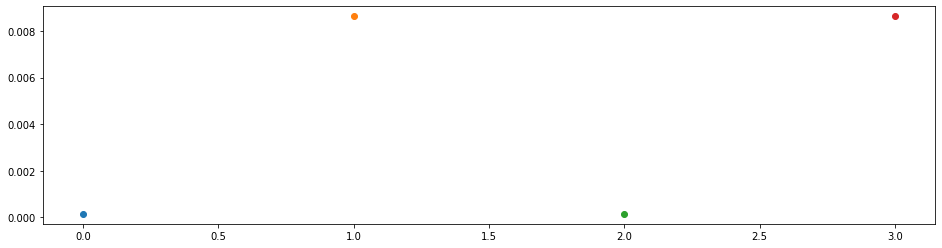

In [22]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

val_performance = {}

#dataset_val = single_step_window.val

for inputs, labels in single_step_window.val.take(10):

#for inputs, labels, lab in tfds.as_numpy(single_step_window.val):

#  print(type(inputs), type(labels), label)

    val_performance['Baseline'] = baseline.evaluate(inputs, labels)
    val_performance['Baseline'] =val_performance['Baseline']  +val_performance['Baseline']

keys = 'Baseline'
fig, ax = plt.subplots(figsize=(16, 4))
for keys in val_performance.keys() :
    i = 0
    for x in val_performance[keys] :
        ax.plot(i, x, 'o')
        i += 1


In [23]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, verbose=1)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=1)

4/4 [==============================] - 0s 0s/step - loss: 1.1813e-04 - mean_absolute_error: 0.0067


### prediction plot with  **fn(plot)**

4/4 [==============================] - 0s 4ms/step - loss: 3.6609e-05 - mean_absolute_error: 0.0043
val_performance :{'Baseline': [4.5400665840134025e-05, 0.004845908842980862], 'Baseline_wide': [3.660891161416657e-05, 0.004330787807703018]}
test_performance :{'Baseline': [0.00011813247692771256, 0.006658655591309071], 'Baseline_wide': [5.4752839787397534e-05, 0.00552209559828043]}


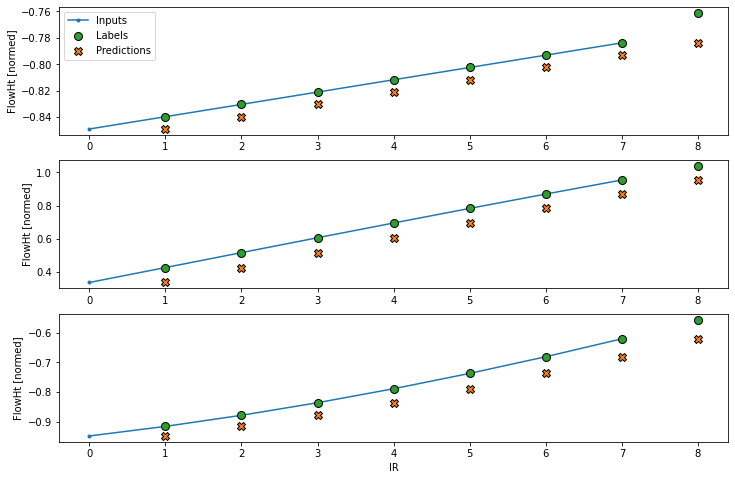

In [24]:
wide_window = WindowGenerator(
    input_width=8, label_width=8, shift=1,
    label_columns=['FlowHt'])

wide_window


wide_window.plot(baseline)

val_performance['Baseline_wide'] = baseline.evaluate(wide_window.val)
performance['Baseline_wide'] = baseline.evaluate(wide_window.test, verbose=0)

print(f'val_performance :{val_performance}')
print(f'test_performance :{performance}')

## Modify Plot_batch for general purposes
- includes predictions
- for all batch data or the required batch set
- plot a total data in one figure

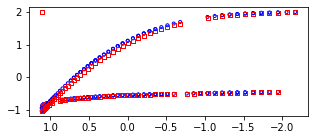

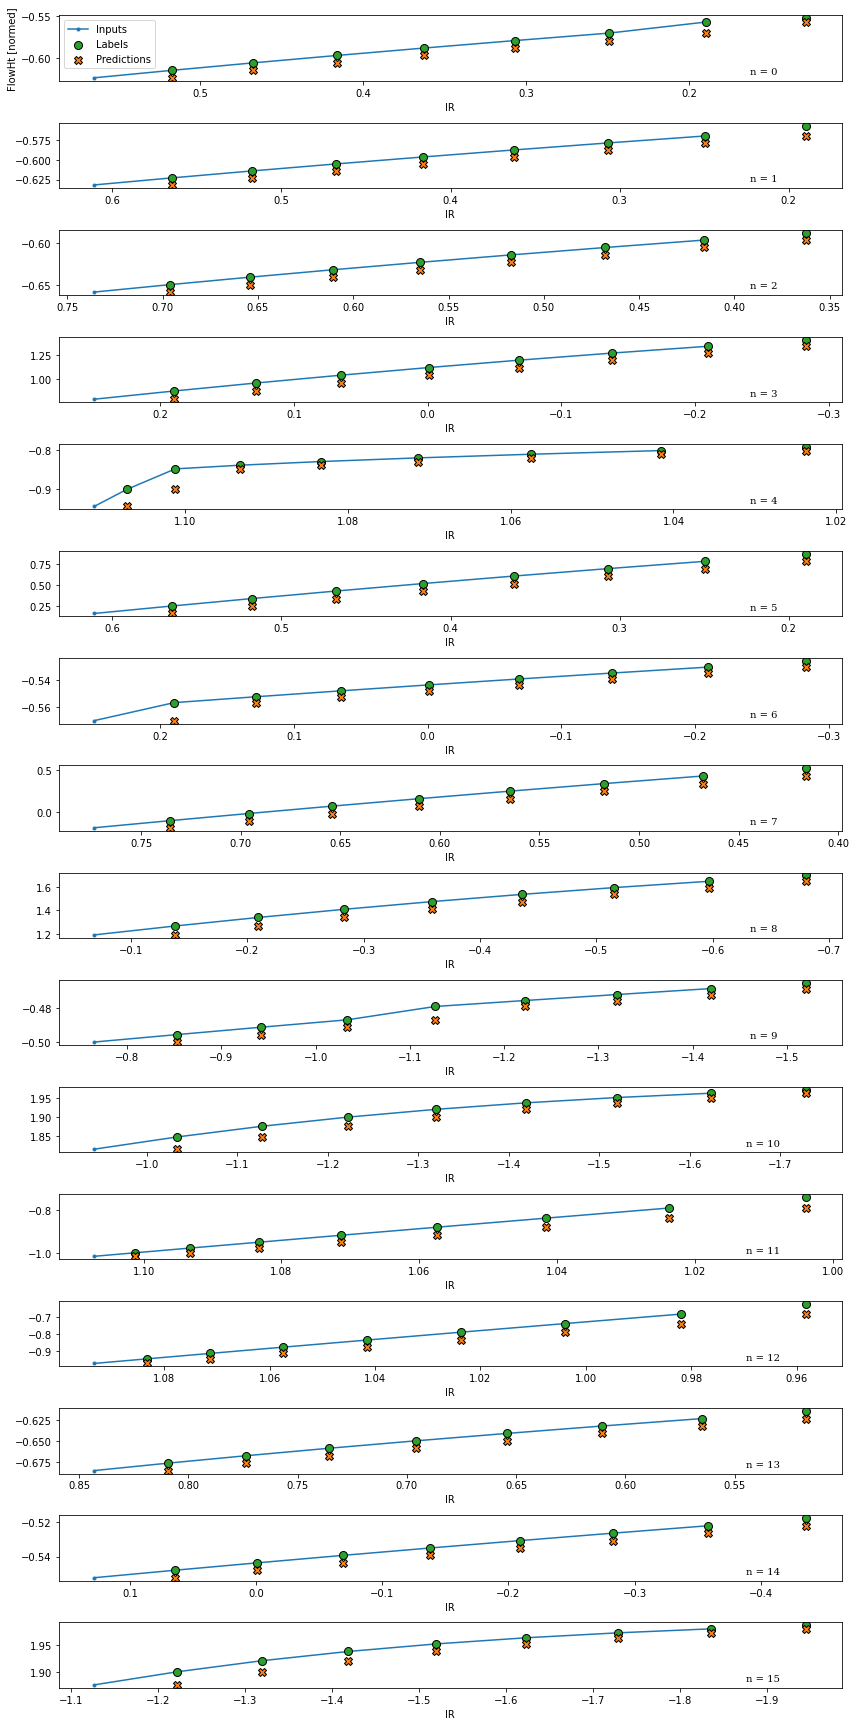

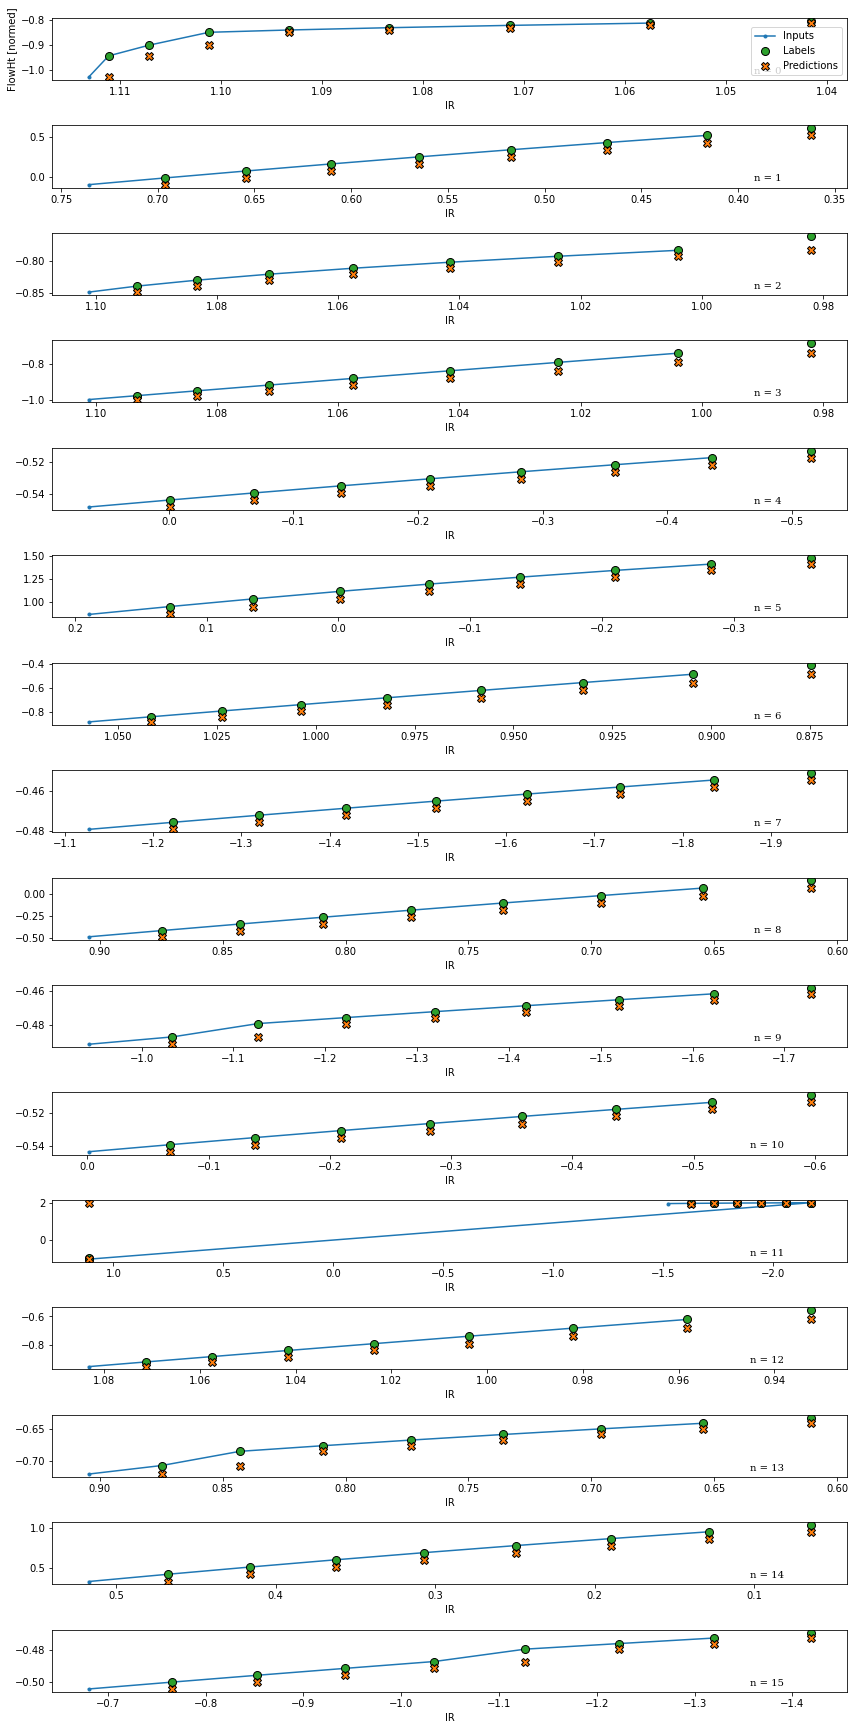

In [25]:
def plot_batch(self, model=None, dset_name=None, plot_col='FlowHt', max_subplots=40, n_batch=None):

  font = { 'family': 'serif', 'color' : 'black', 'weight': 'normal', 'size'  :  10}
# for WinGen() window object(instance ?)

  if dset_name == 'train':
        dataset = self.train
  elif dset_name == 'val':
        dataset = self.val
  elif dset_name == 'test' :
        dataset = self.test
  else :
        dataset = self.train

  if model is not None :
        fig, ax2 = plt.subplots(figsize =(5,2))



  for i, batch in enumerate(dataset) :
        inputs, labels, lab = batch
        nrows = len(inputs)
        fvsize = nrows * 1.5
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        fig, ax = plt.subplots(nrows, ncols=1, figsize = (12,fvsize), tight_layout = True)
        for n in range(max_n):
#           plt.plot(self.input_indices, inputs[n, :, plot_col_index],
            ax[n].plot(inputs[n, :, 0], inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
            ax[n].text(0.9,0.1, "n = {}".format(n), fontdict =font, ha="center", transform=ax[n].transAxes)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            ax[n].scatter(lab[n,:, 0], labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                ax2.scatter(lab[n,:,0], labels[n, :, label_col_index],
                marker='.',facecolors='none', edgecolors='b' )

            if model is not None:
              predictions = model(inputs)
              ax[n].scatter(lab[n,:, 0],  predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                                facecolors='none',  c='#ff7f0e', s=64)
              ax2.scatter(lab[n,:, 0],   predictions[n, :, label_col_index],
                  marker=',', label='Predictions', facecolors='none', edgecolors='r',
                           s=16)

            if n == 0:
                ax[n].legend()

                ax[n].set_ylabel(f'{plot_col} [normed]')
             #   ax[n].set_ylim([-1.5, 0.1])
             #   ax[n].set_xlim([-2.2, 1.12])
            ax[n].invert_xaxis()

            ax[n].set_xlabel('IR')
        if n_batch is not None :
            if n_batch <= i :
                break
            else:
                continue
        else :
            continue

  if model is not None :
      ax2.invert_xaxis()
#  ax2.legend( )

WinGen.plot_batch = plot_batch


wide_window_t.plot_batch(baseline, n_batch=1)


### 선형 모델

In [26]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [27]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (16, 1, 6)
Output shape: (16, 1, 1)


## Complie and Fit function

In [28]:
MAX_EPOCHS =100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val)
#                      ,callbacks=[early_stopping])
  return history

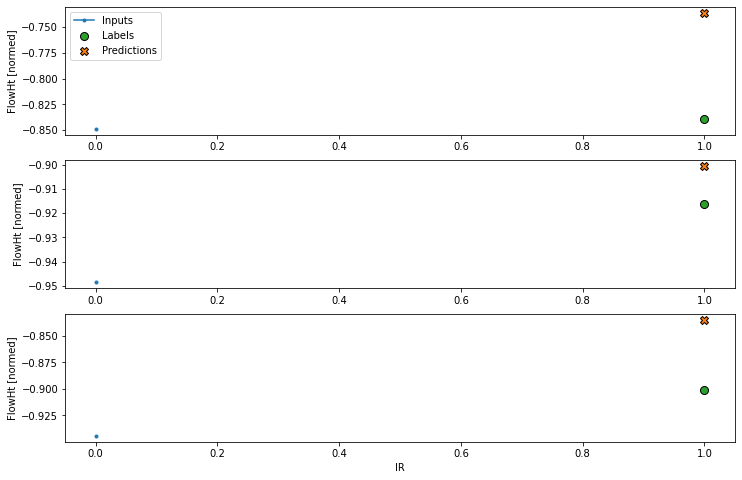

In [29]:
hist = compile_and_fit(linear, single_step_window )
IPython.display.clear_output()
single_step_window.plot(linear)

In [30]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (16, 8, 6)
Output shape: (16, 8, 1)


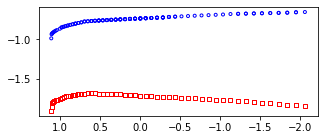

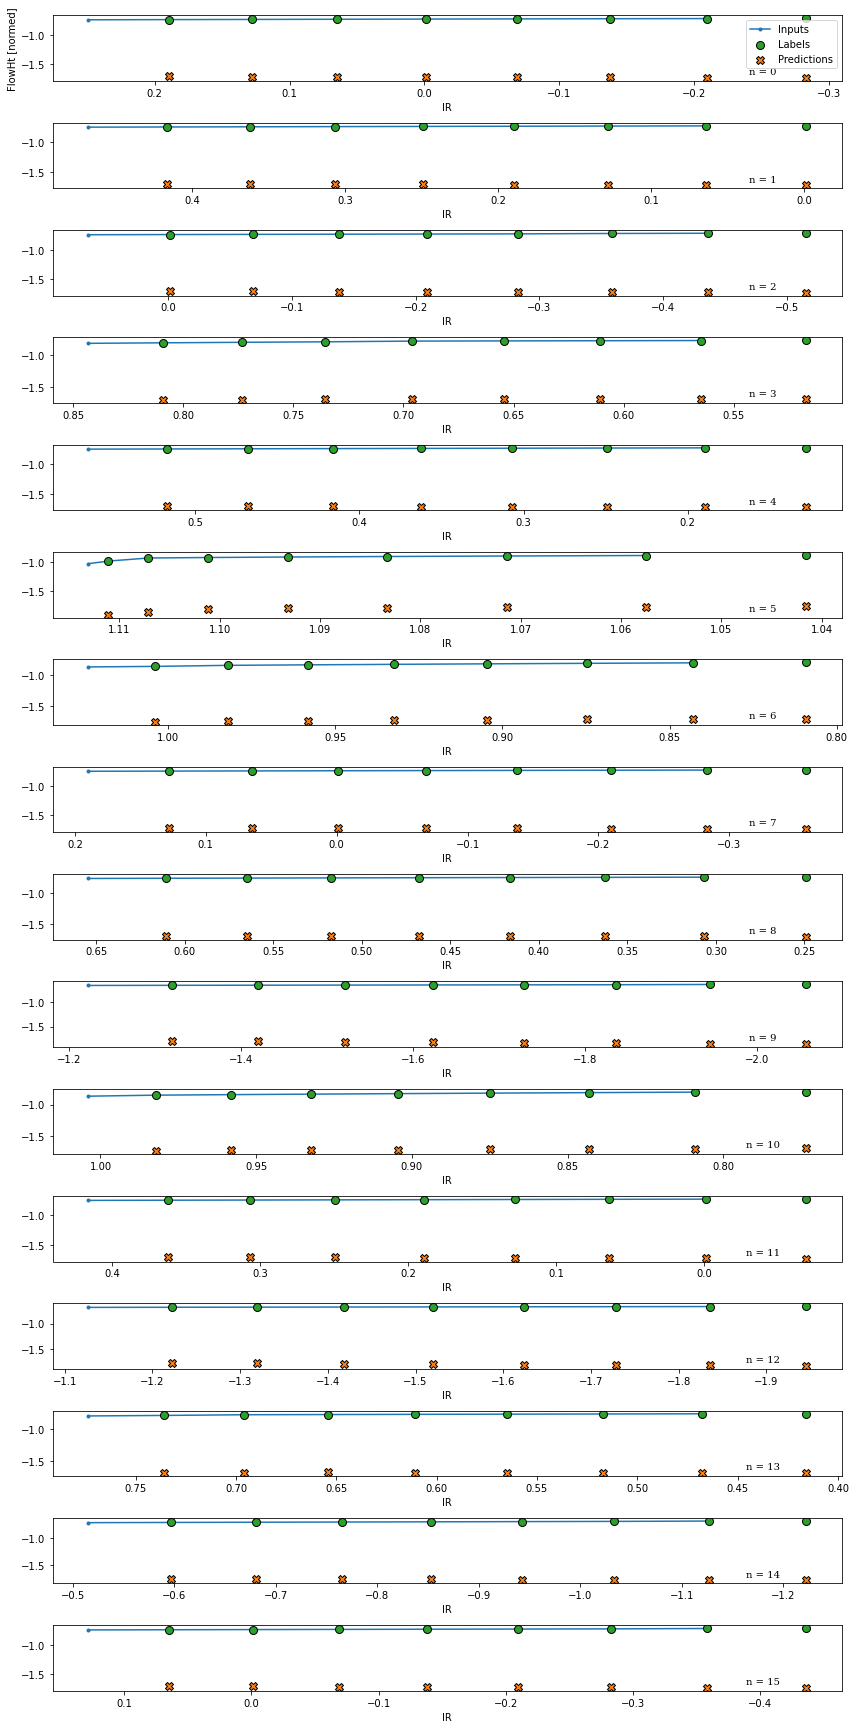

In [31]:
wide_window_t.plot_batch(linear, dset_name='test', n_batch=0)

In [32]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test)

val_performance['Linear'] = linear.evaluate(single_step_window.train)

8/8 [==============================] - 0s 0s/step - loss: 0.0776 - mean_absolute_error: 0.0912


In [55]:
hist = linear.fit(wide_window.train, epochs=MAX_EPOCHS,
                      validation_data=wide_window.val)

IPython.display.clear_output()

## Learing history

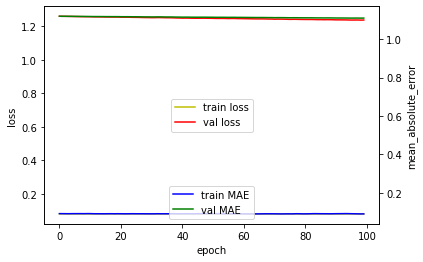

In [56]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['mean_absolute_error'], 'b', label='train MAE')
acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val MAE')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mean_absolute_error')

#loss_ax.legend(loc='upper left')
#acc_ax.legend(loc='lower left')
loss_ax.legend(loc='center')
acc_ax.legend(loc='lower center')

plt.show()


In [34]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (16, 8, 6)
Output shape: (16, 8, 1)


In [35]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (16, 8, 6)
Output shape: (16, 8, 1)


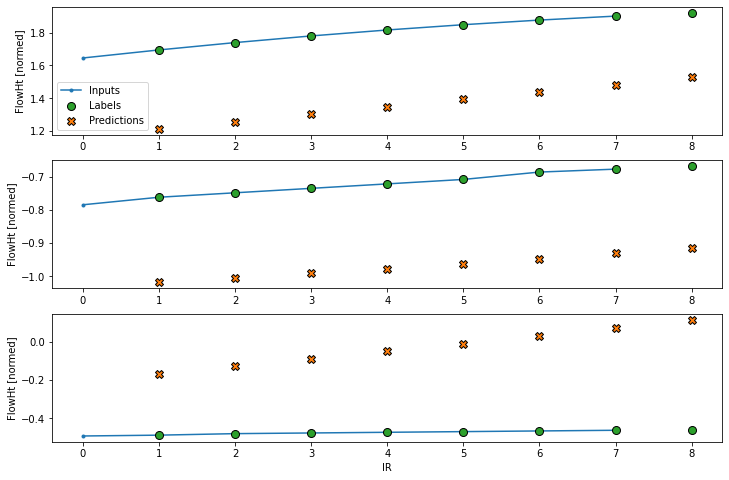

In [36]:
hist = compile_and_fit(linear, wide_window )

wide_window.plot(linear)

IPython.display.clear_output()

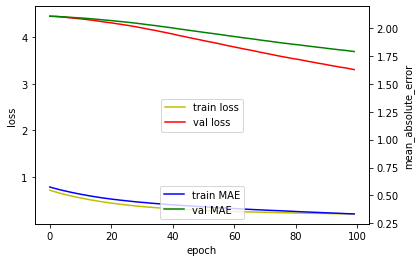

In [37]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['mean_absolute_error'], 'b', label='train MAE')
acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val MAE')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mean_absolute_error')

#loss_ax.legend(loc='upper left')
#acc_ax.legend(loc='lower left')
loss_ax.legend(loc='center')
acc_ax.legend(loc='lower center')

plt.show()


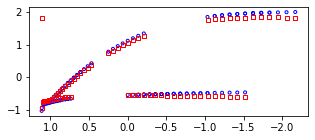

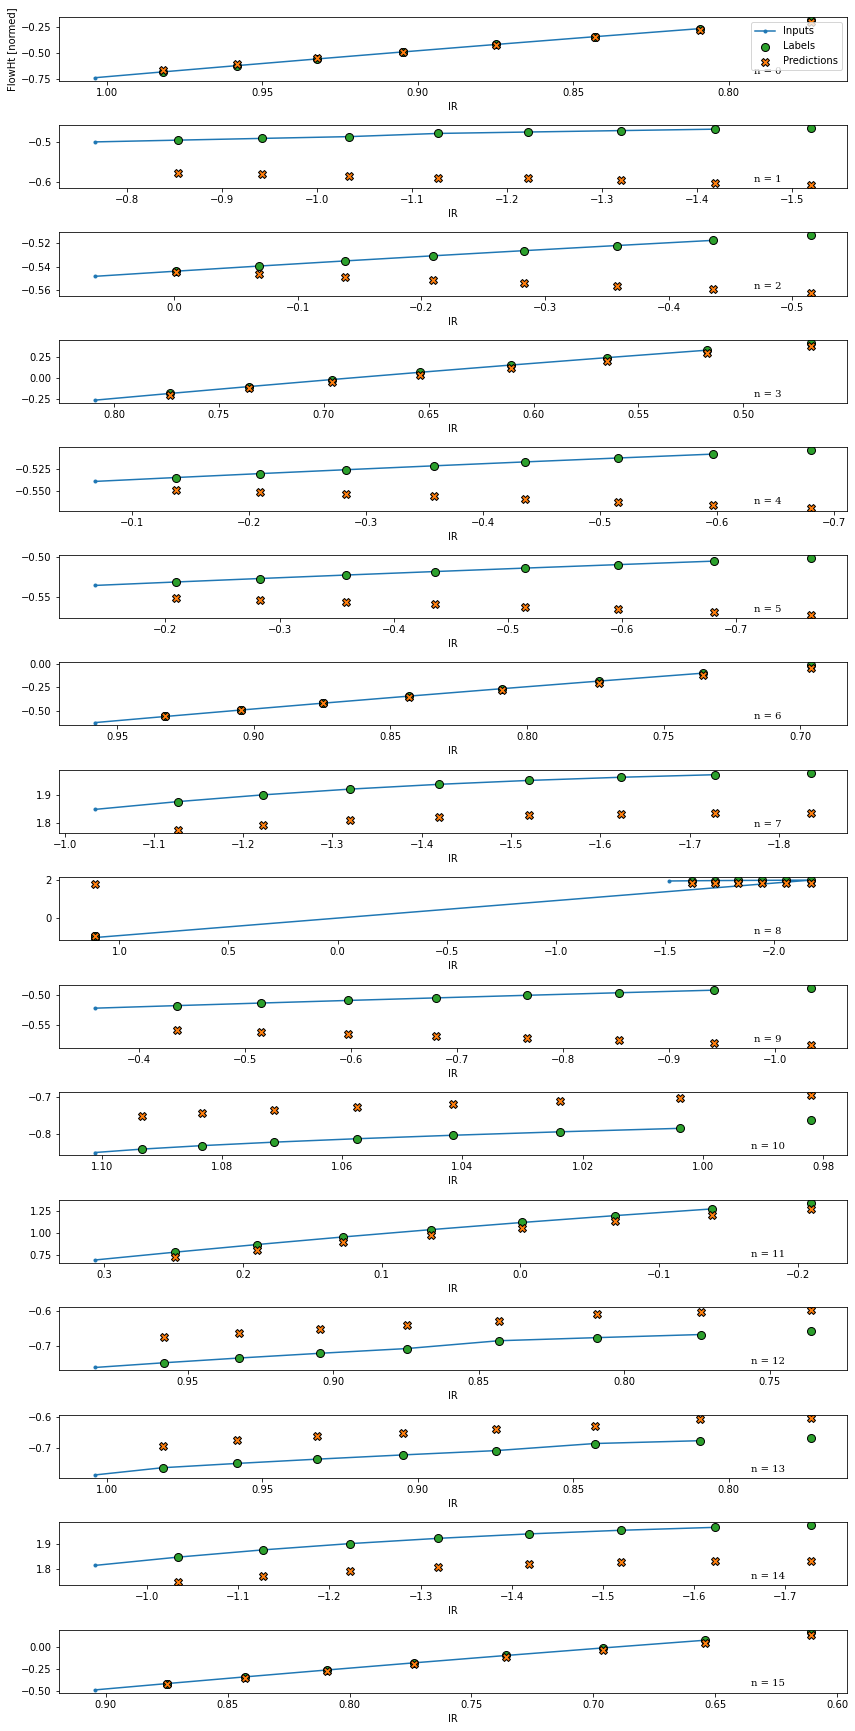

In [58]:
# compile_and_fit(linear, wide_window_t) # error because wide_window_t.train returns inputs, labes and lab

wide_window_t.plot_batch(linear, n_batch=0)



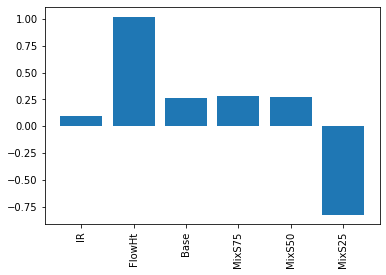

In [59]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### 밀집

In [60]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

hist = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

IPython.display.clear_output()

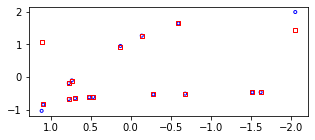

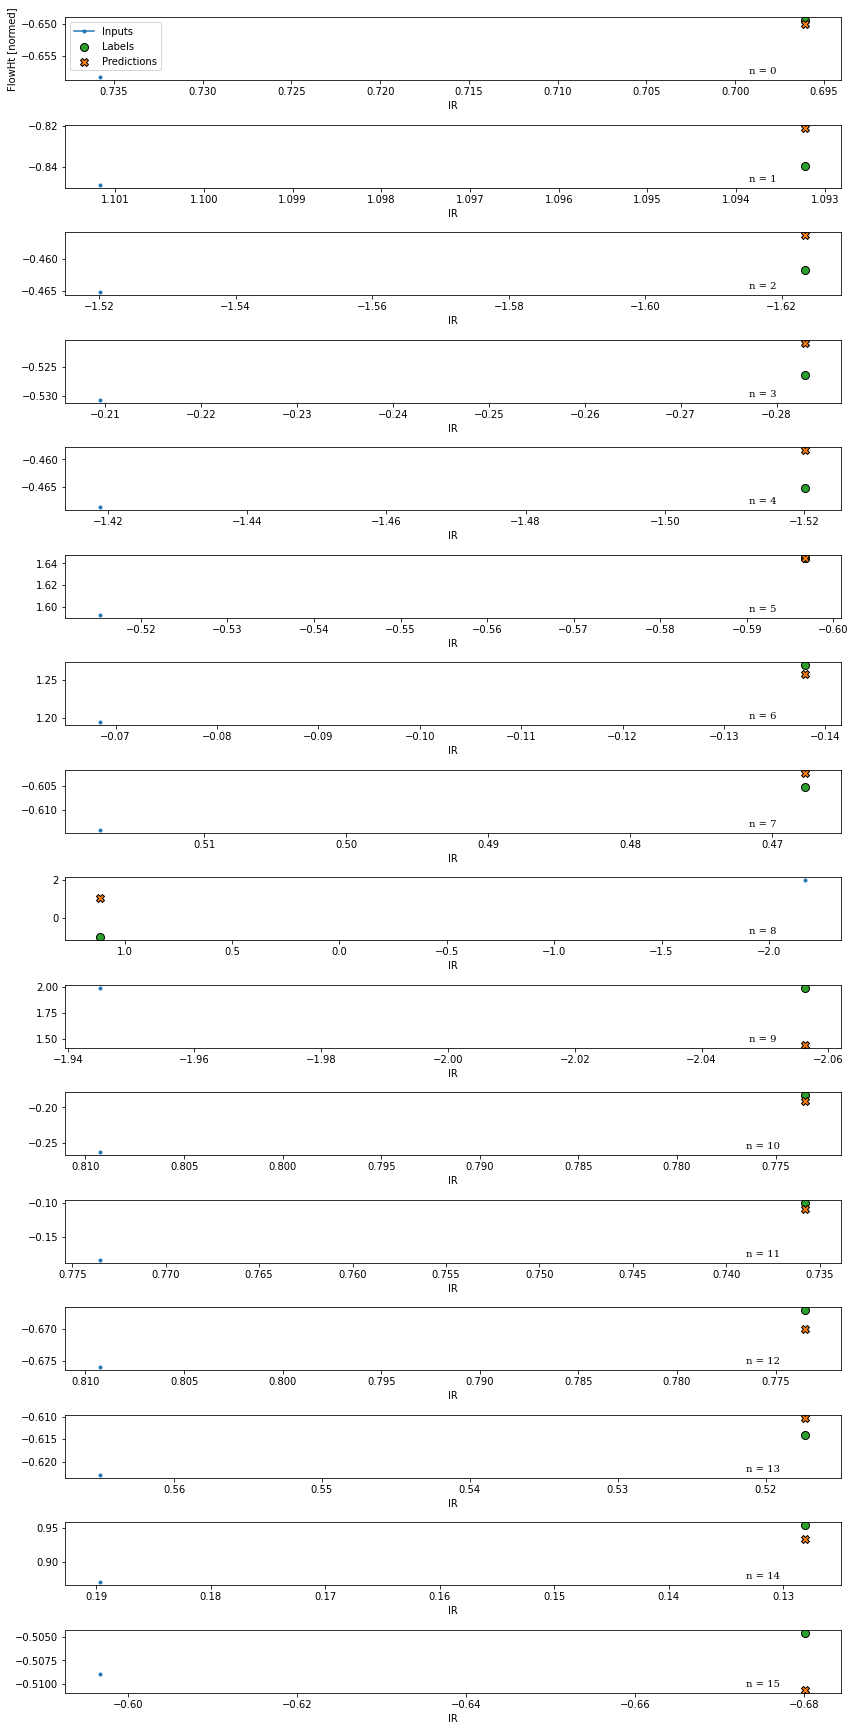

In [61]:
single_step_window_t.plot_batch(dense, n_batch=0)

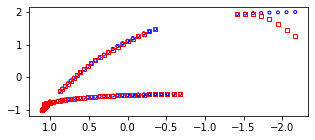

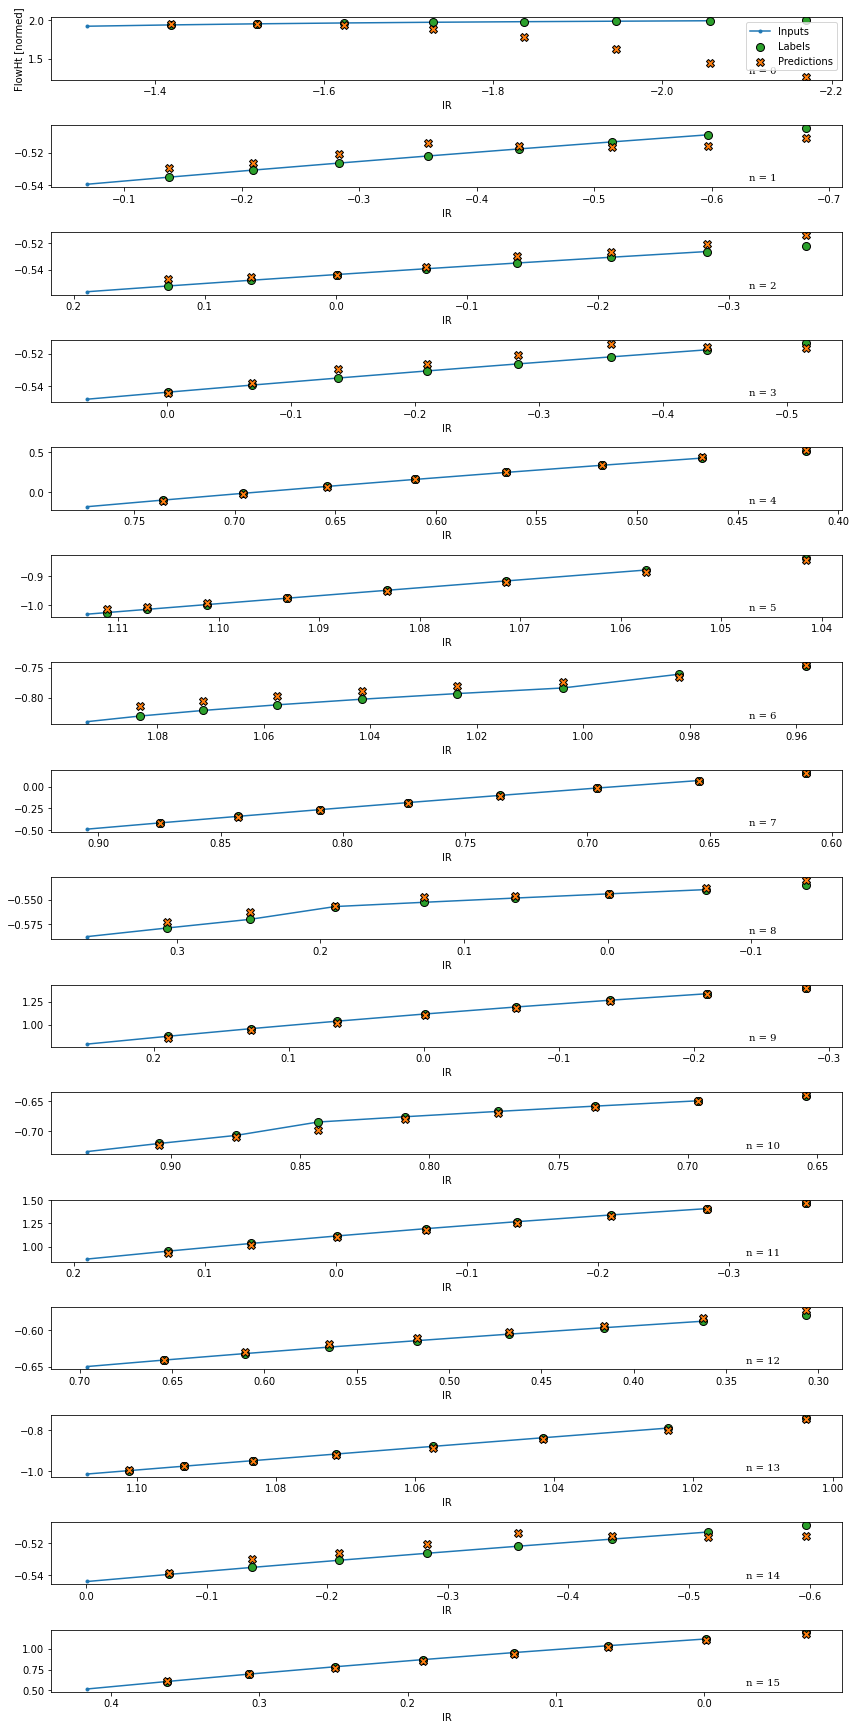

In [62]:
wide_window_t.plot_batch(dense, n_batch=0)

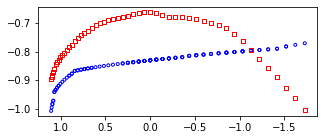

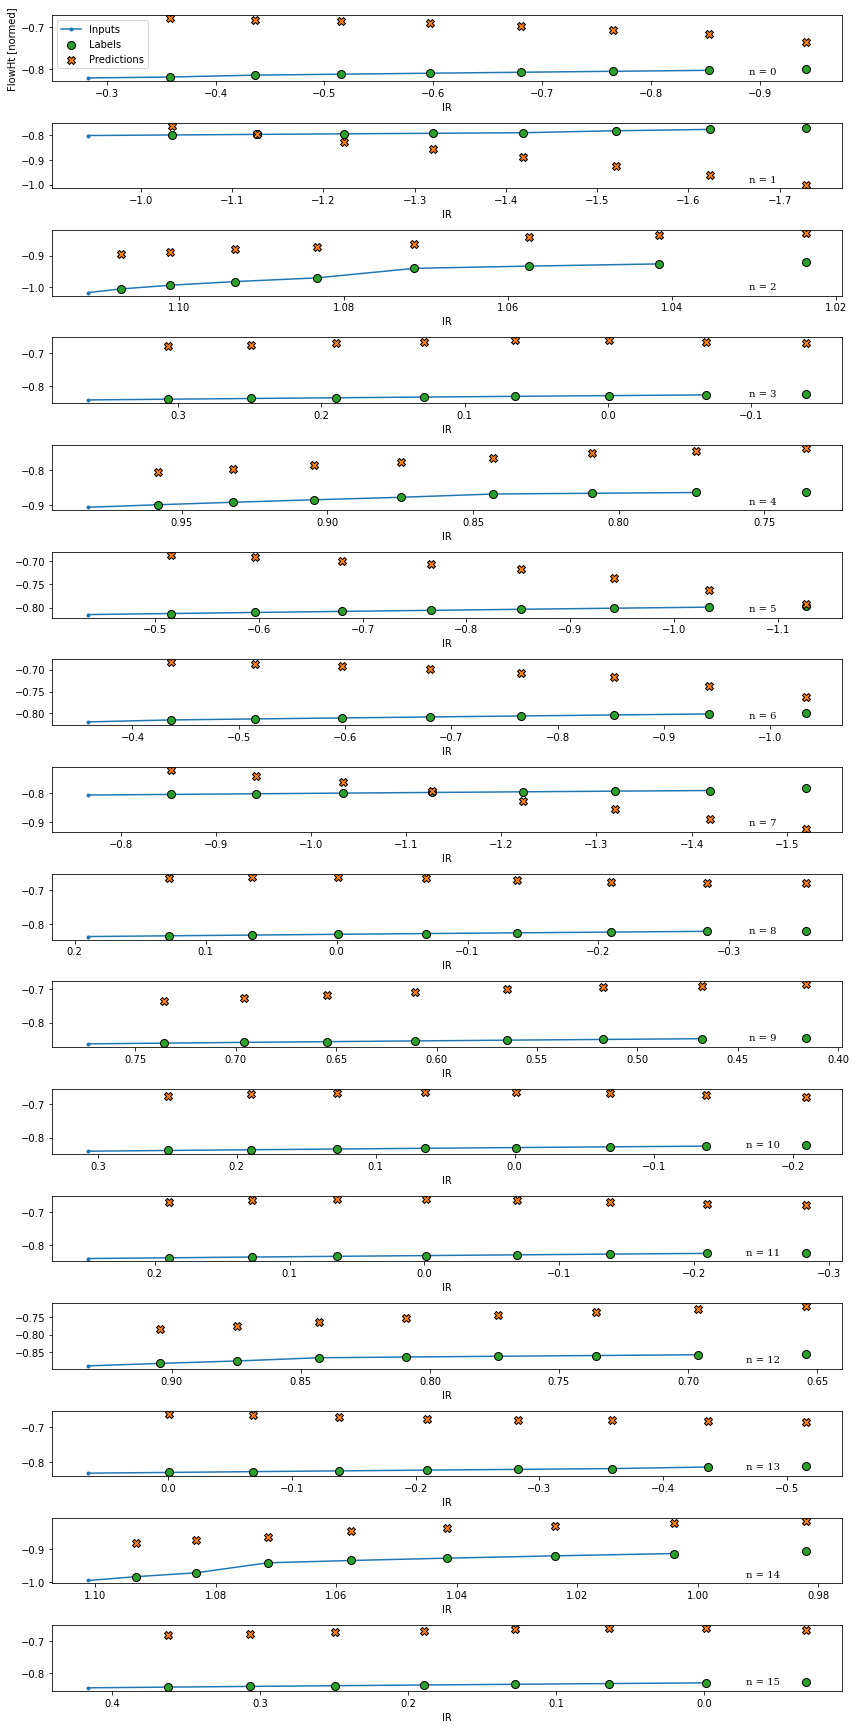

In [68]:
wide_window_t.plot_batch(dense, dset_name='val', n_batch=0)


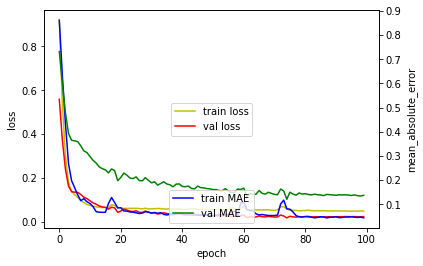

In [63]:
# 5. 모델 학습 과정 표시하기

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['mean_absolute_error'], 'b', label='train MAE')
acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val MAE')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mean_absolute_error')

#loss_ax.legend(loc='upper left')
#acc_ax.legend(loc='lower left')
loss_ax.legend(loc='center')
acc_ax.legend(loc='lower center')

plt.show()


### 다중 스텝 밀집

In [69]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['FlowHt'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['FlowHt']

In [70]:
CONV_WIDTH = 3
conv_window_t = WinGen(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['FlowHt'])

conv_window_t

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['FlowHt']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

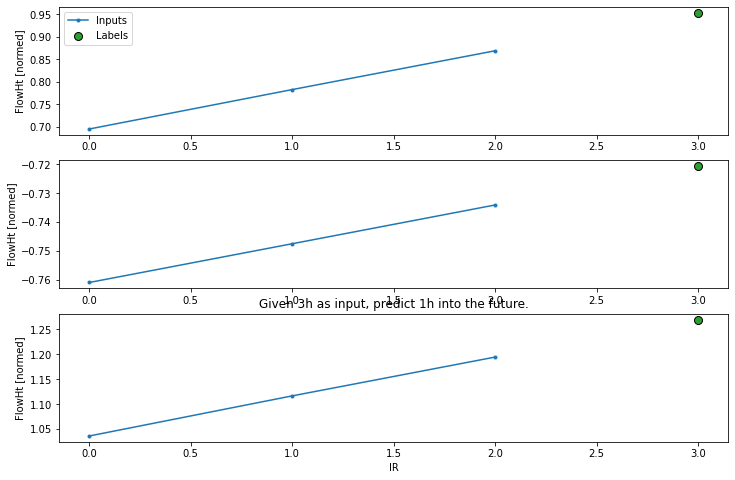

In [71]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

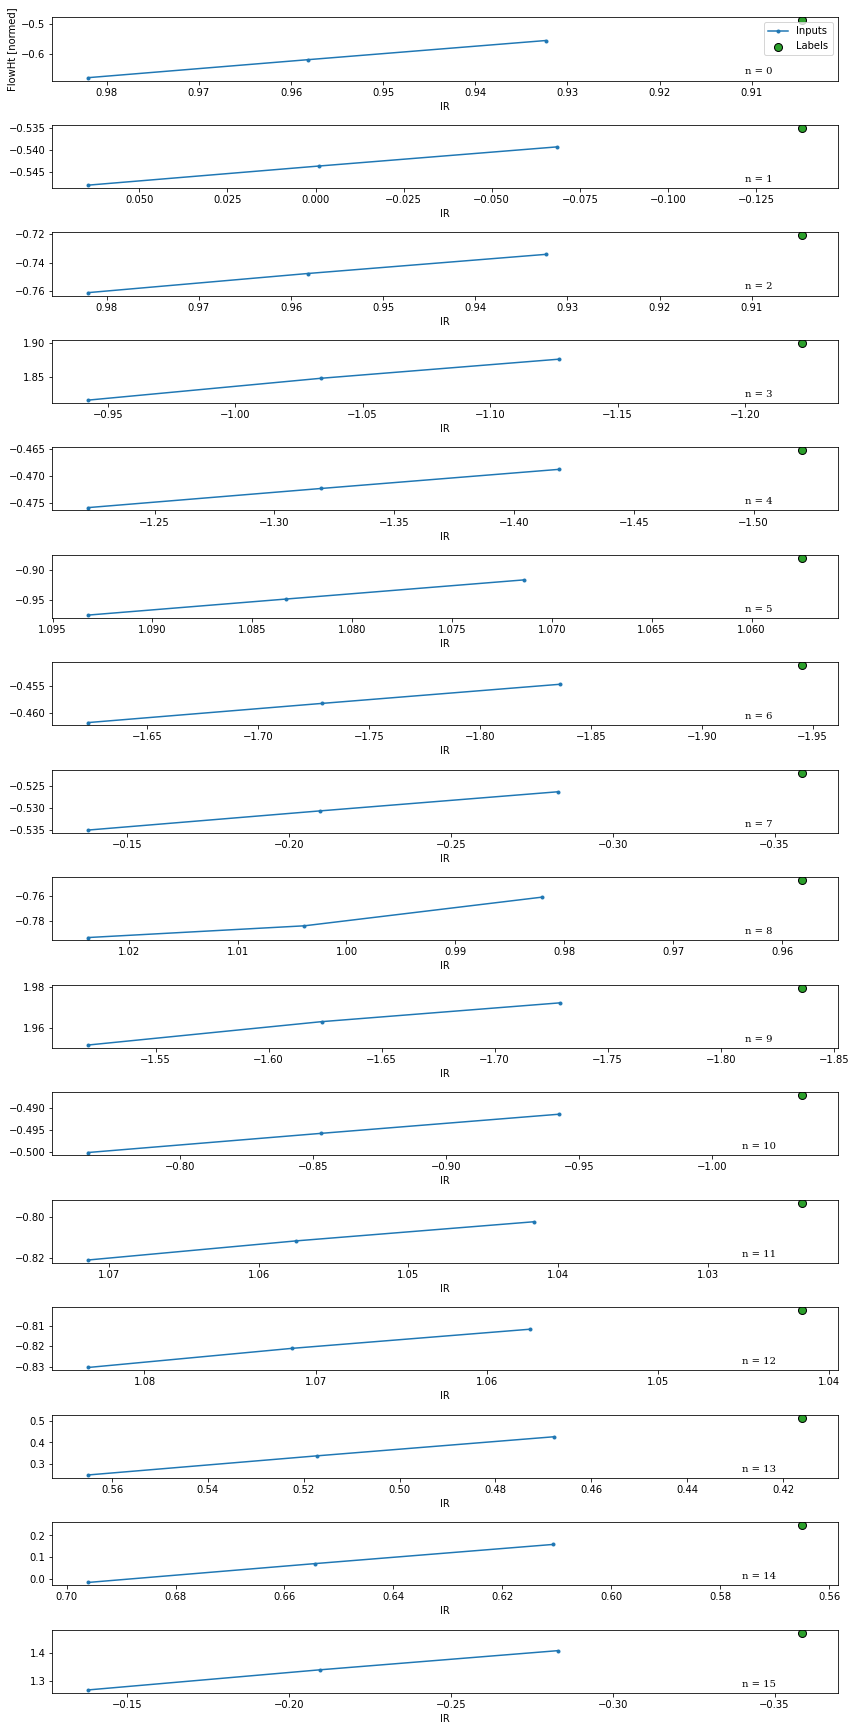

In [72]:
conv_window_t.plot_batch(n_batch=0)

`layers.Flatten`을 모델의 첫 번째 레이어로 추가하여 다중 입력 스텝 창에서 `dense` 모델을 훈련할 수 있습니다.

In [73]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [49]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (16, 3, 6)
Output shape: (16, 1, 1)


In [74]:
hist = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)
IPython.display.clear_output()

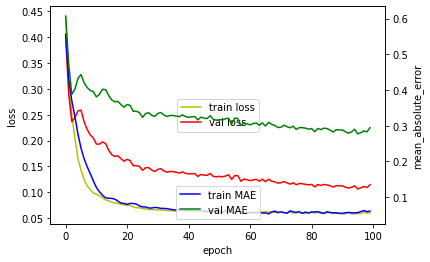

In [75]:
# 5. 모델 학습 과정 표시하기

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['mean_absolute_error'], 'b', label='train MAE')
acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val MAE')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mean_absolute_error')

#loss_ax.legend(loc='upper left')
#acc_ax.legend(loc='lower left')
loss_ax.legend(loc='center')
acc_ax.legend(loc='lower center')

plt.show()

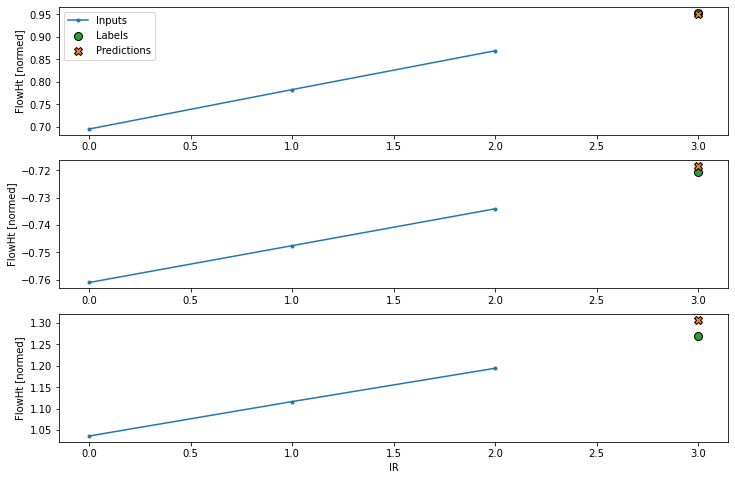

In [76]:
conv_window.plot(multi_step_dense)

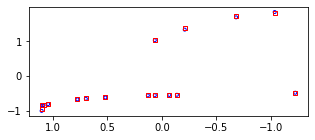

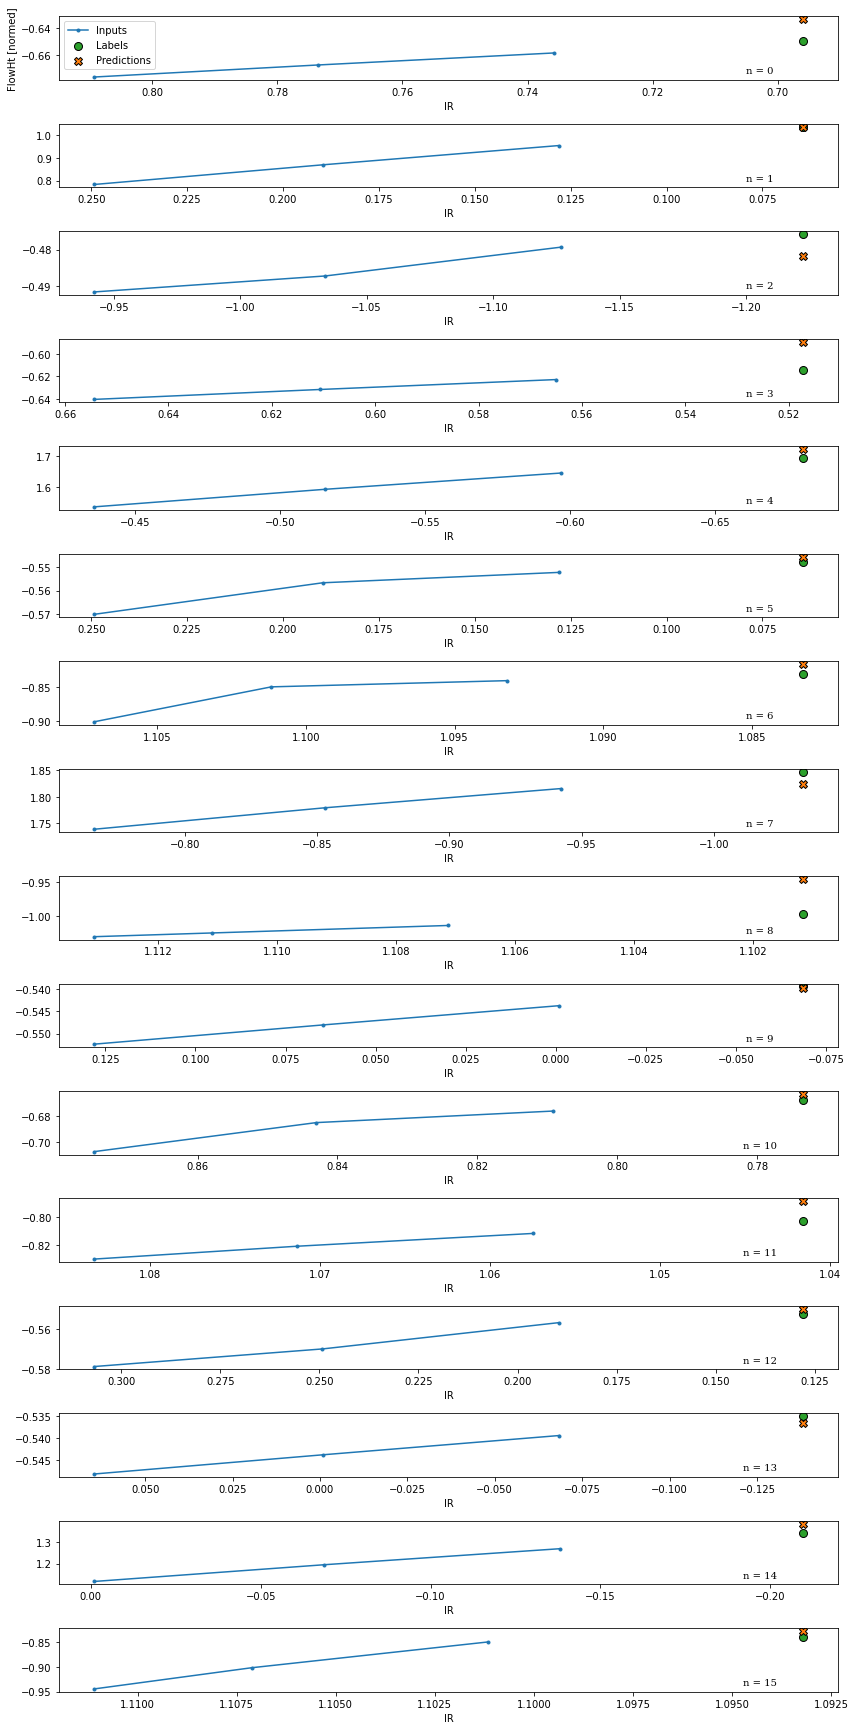

In [80]:
conv_window_t.plot_batch(multi_step_dense, n_batch=0)

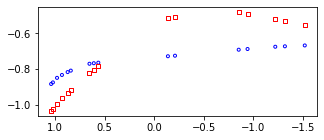

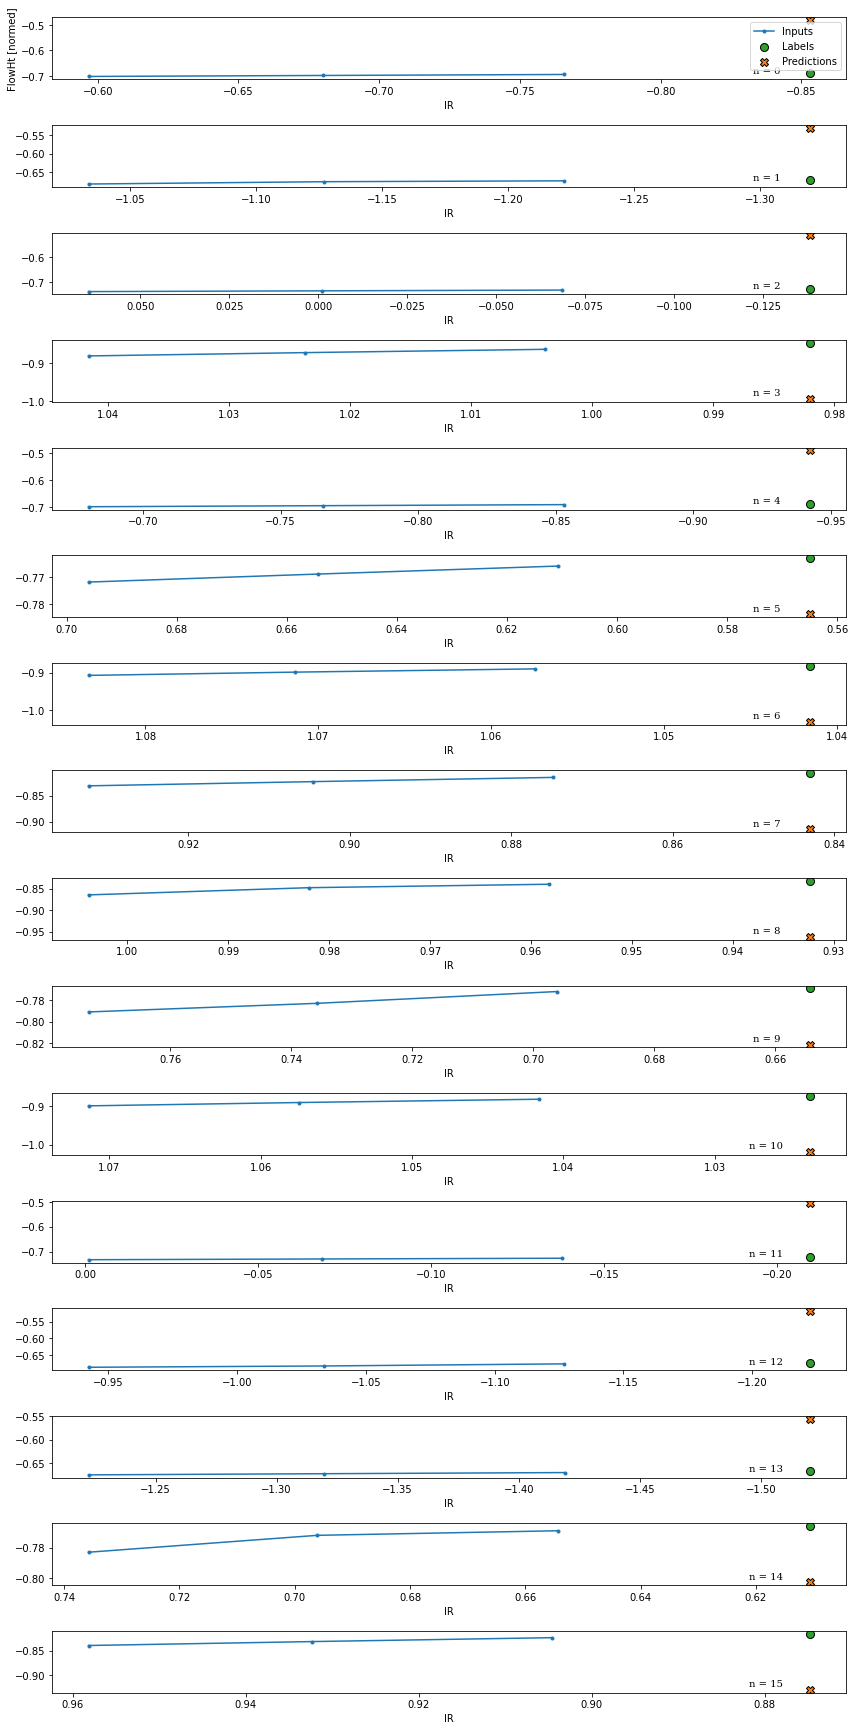

In [84]:
conv_window_t.plot_batch(multi_step_dense, dset_name='test', n_batch=0)


이 접근법의 주된 단점은 결과적인 모델이 정확히 이 형상의 입력 창에서만 실행될 수 있다는 것입니다. 

In [78]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (16, 8, 6)

InvalidArgumentError:Matrix size-incompatible: In[0]: [16,48], In[1]: [18,16] [Op:MatMul]


다음 섹션의 컨볼루셔널 모델은 이 문제를 해결합니다.

### 컨볼루션 신경망

컨볼루션 레이어(`layers.Conv1D`)도 각 예측에 대한 입력으로 여러 타임스텝을 사용합니다.

다음은 컨볼루션으로 다시 작성한 `multi_step_dense`와 **동일한** 모델입니다.

다음 변경 사항에 주목하세요.

- `layers.Flatten`과 첫 번째 `layers.Dense`는 `layers.Conv1D`로 대체됩니다.
- 컨볼루션이 출력에서 시간 축을 유지하므로 `layers.Reshape`는 이 더 이상 필요하지 않습니다.

In [85]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])



예제 배치에서 실행하여 모델이 예상된 형상으로 출력을 생성하는지 확인합니다.

In [56]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (16, 3, 6)
Output shape: (16, 1, 1)


In [86]:
n=1
for example_inputs, example_labels in conv_window.train.take(30): #1534, 6
#for example_inputs, example_labels in single_step_window.train.take(3):
#for example_inputs, example_labels in wide_window.train.take(2000): #1533 15
  print(n)
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
  n += 1


1
Inputs shape (batch, time, features): (16, 3, 6)
Labels shape (batch, time, features): (16, 1, 1)
2
Inputs shape (batch, time, features): (16, 3, 6)
Labels shape (batch, time, features): (16, 1, 1)
3
Inputs shape (batch, time, features): (16, 3, 6)
Labels shape (batch, time, features): (16, 1, 1)
4
Inputs shape (batch, time, features): (16, 3, 6)
Labels shape (batch, time, features): (16, 1, 1)
5
Inputs shape (batch, time, features): (16, 3, 6)
Labels shape (batch, time, features): (16, 1, 1)
6
Inputs shape (batch, time, features): (16, 3, 6)
Labels shape (batch, time, features): (16, 1, 1)
7
Inputs shape (batch, time, features): (16, 3, 6)
Labels shape (batch, time, features): (16, 1, 1)
8
Inputs shape (batch, time, features): (1, 3, 6)
Labels shape (batch, time, features): (1, 1, 1)


`conv_window`에서 훈련하고 평가하면 `multi_step_dense` 모델과 유사한 성능을 제공해야 합니다.

In [87]:
hist = compile_and_fit(conv_model, conv_window)

#IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)
#performance['Conv'] = conv_model.evaluate(conv_window.test)

IPython.display.clear_output()

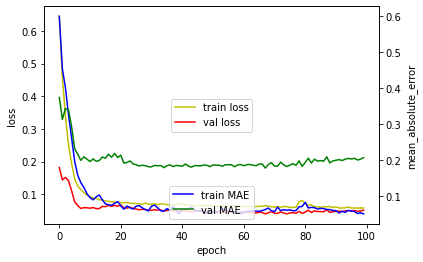

In [88]:
# 5. 모델 학습 과정 표시하기
def eval(hist) :
    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

    acc_ax.plot(hist.history['mean_absolute_error'], 'b', label='train MAE')
    acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val MAE')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('mean_absolute_error')

    #loss_ax.legend(loc='upper left')
    #acc_ax.legend(loc='lower left')
    loss_ax.legend(loc='center')
    acc_ax.legend(loc='lower center')

    plt.show()

eval(hist)



이 `conv_model`과 `multi_step_dense` 모델의 차이점은 `conv_model`은 모든 길이의 입력에서 실행될 수 있다는 것입니다. 컨볼루셔널 레이어는 입력의 슬라이딩 윈도우에 적용됩니다.

![Executing a convolutional model on a sequence](https://www.tensorflow.org/tutorials/structured_data/images/wide_conv_window.png)

더 넓은 입력에서 실행하면 더 넓은 출력이 생성됩니다.

In [60]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (16, 8, 6)
Labels shape: (16, 8, 1)
Output shape: (16, 6, 1)


출력은 입력보다 짧습니다. 훈련 또는 플롯 작업을 수행하려면 레이블과 예상의 길이가 동일해야 합니다. 따라서 레이블과 예측 길이가 일치하도록 몇 개의 추가 입력 타임스텝으로 넓은 창을 생성하는 `WindowGenerator`를 빌드합니다. 

In [89]:
LABEL_WIDTH = 8
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['FlowHt'])

wide_conv_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 3  4  5  6  7  8  9 10]
Label column name(s): ['FlowHt']

In [91]:
wide_conv_window_t = WinGen(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['FlowHt'])

wide_conv_window_t

print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (16, 10, 6)
Labels shape: (16, 8, 1)
Output shape: (16, 8, 1)


In [63]:
n=1
for example_inputs, example_labels in wide_conv_window.train.take(200): #1534, 6
#for example_inputs, example_labels in single_step_window.train.take(3):
#for example_inputs, example_labels in wide_window.train.take(2000): #1533 15
  print(n)
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
  n += 1

1
Inputs shape (batch, time, features): (16, 10, 6)
Labels shape (batch, time, features): (16, 8, 1)
2
Inputs shape (batch, time, features): (16, 10, 6)
Labels shape (batch, time, features): (16, 8, 1)
3
Inputs shape (batch, time, features): (16, 10, 6)
Labels shape (batch, time, features): (16, 8, 1)
4
Inputs shape (batch, time, features): (16, 10, 6)
Labels shape (batch, time, features): (16, 8, 1)
5
Inputs shape (batch, time, features): (16, 10, 6)
Labels shape (batch, time, features): (16, 8, 1)
6
Inputs shape (batch, time, features): (16, 10, 6)
Labels shape (batch, time, features): (16, 8, 1)
7
Inputs shape (batch, time, features): (10, 10, 6)
Labels shape (batch, time, features): (10, 8, 1)


이제 더 넓은 창에 모델의 예측값을 플롯할 수 있습니다. 첫 번째 예측 전 3개의 입력 타임스텝에 주목하세요. 여기서 모든 예측은 이전 3개의 타임스텝에 기초합니다.

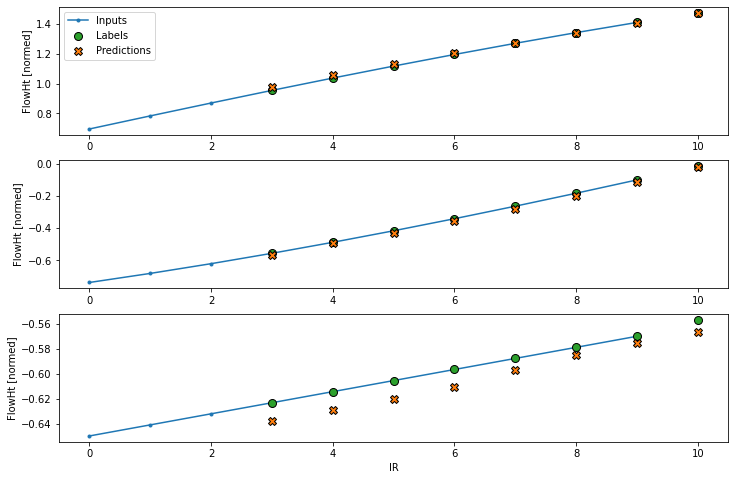

In [92]:
wide_conv_window.plot(conv_model)

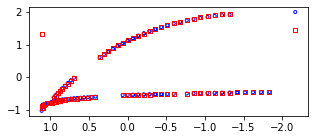

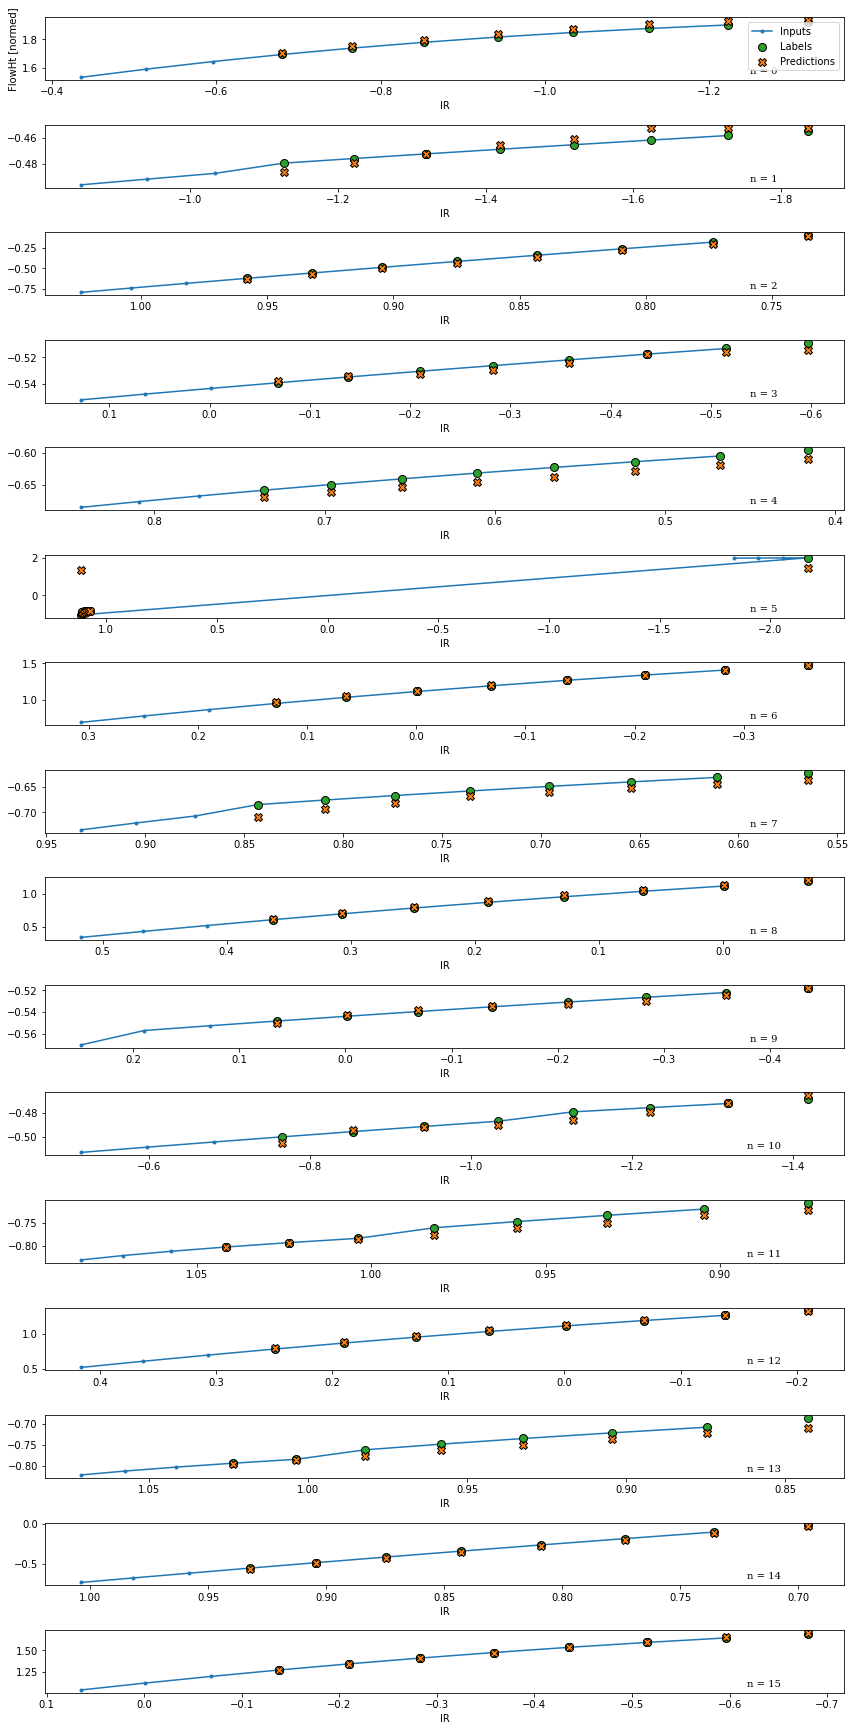

In [93]:
wide_conv_window_t.plot_batch(conv_model,n_batch =0)

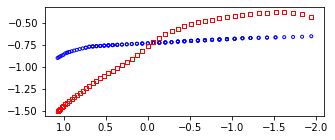

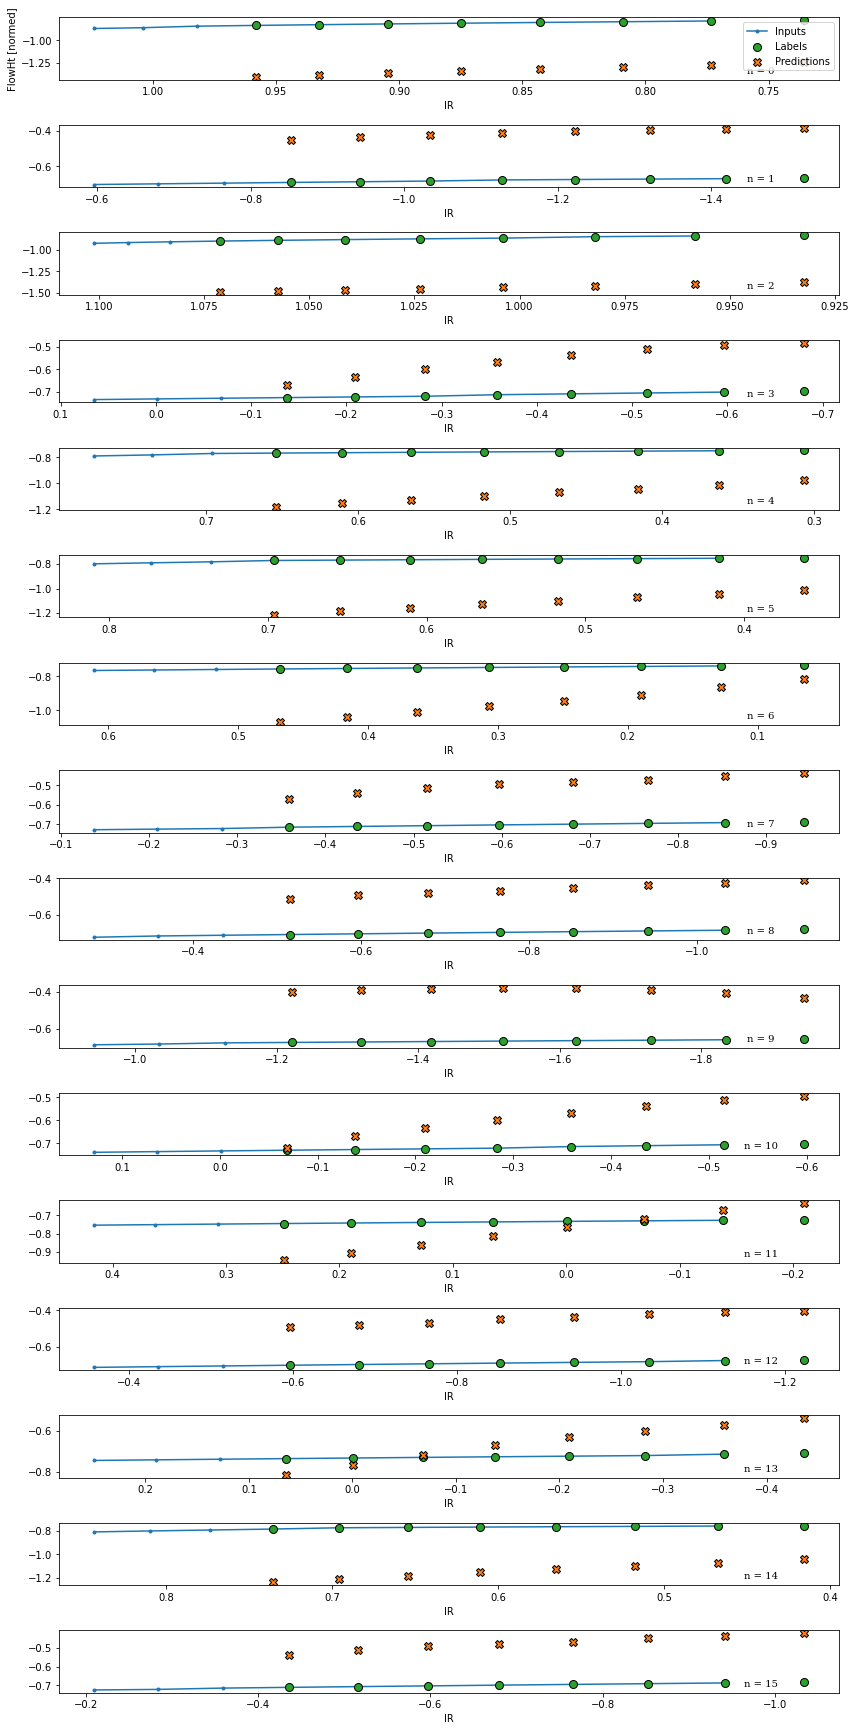

In [95]:
wide_conv_window_t.plot_batch(conv_model, dset_name='test',n_batch =0)

### 순환 신경망

Recurrent Neural Network(RNN)는 시계열 데이터에 적합한 신경망 유형입니다. RNN은 시계열을 단계별로 처리하여 타임스텝 사이에서 내부 상태를 유지합니다.

자세한 내용은 [텍스트 생성 튜토리얼](https://www.tensorflow.org/tutorials/text/text_generation) 또는 [RNN 가이드](https://www.tensorflow.org/guide/keras/rnn)를 읽어보세요.

이 튜토리얼에서는 [Long Short Term Memory](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)(LSTM)이라는 RNN 레이어를 사용합니다.

모든 keras RNN 레이어에 대한 중요한 생성자 인수는 `return_sequences` 인수입니다. 이 설정은 다음 두 가지 방법 중 하나로 레이어를 구성할 수 있습니다.

1. 기본값인 `False`인 경우 레이어는 최종 타임스텝의 출력만 반환하여 단일 예측을 수행하기 전에 모델이 내부 상태를 준비할 시간을 줍니다.

![An lstm warming up and making a single prediction](https://www.tensorflow.org/tutorials/structured_data/images/lstm_1_window.png)

1. `True`이면 레이어가 각 입력에 대한 출력을 반환합니다. 다음과 같은 경우에 유용합니다.

- RNN 레이어 쌓기
- 여러 타임스텝에서 동시에 모델 훈련

![An lstm making a prediction after every timestep](https://www.tensorflow.org/tutorials/structured_data/images/lstm_many_window.png)

In [96]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(16, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

`return_sequences=True`이면 모델을 한 번에 24시간 분량 데이터에 대해 훈련할 수 있습니다.

Note: This will give a pessimistic view of the model's performance. On the first timestep the model has no access to previous steps, and so can't do any better than the simple linear and dense models shown earlier.

In [67]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (16, 8, 6)
Output shape: (16, 8, 1)


In [97]:
hist2 = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
IPython.display.clear_output()

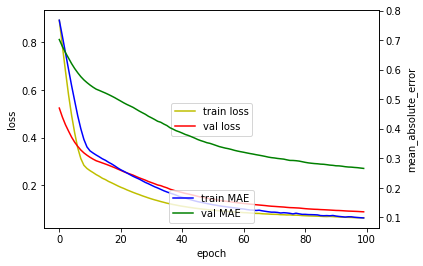

In [98]:
eval(hist2)

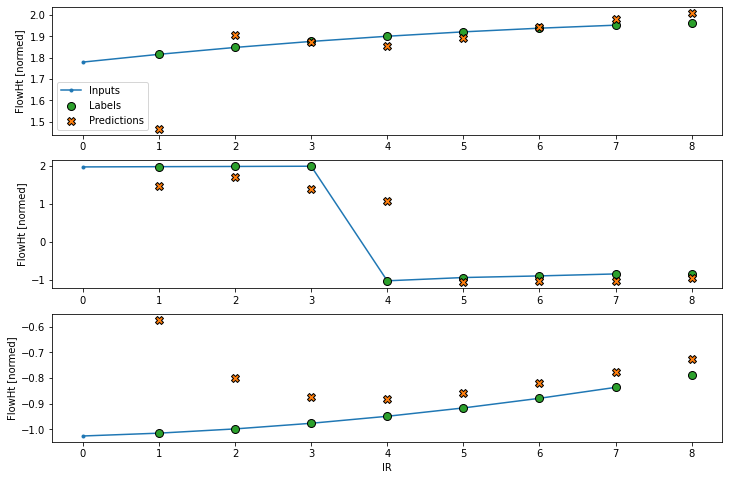

In [99]:
wide_window.plot(lstm_model)

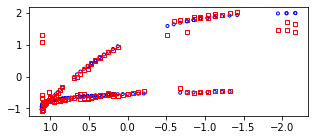

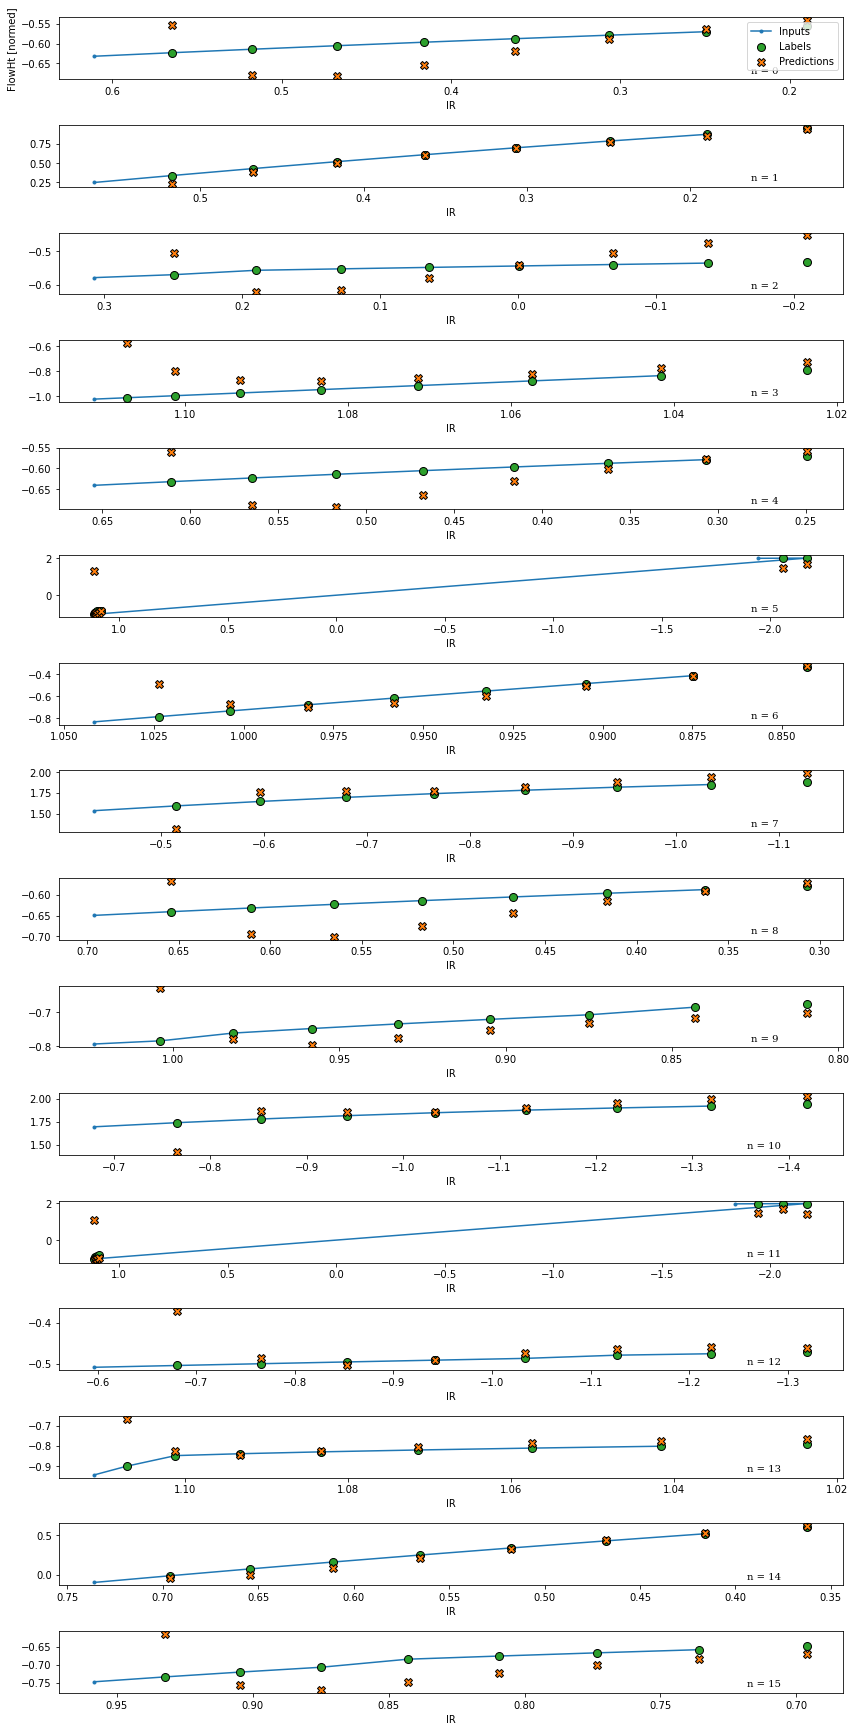

In [100]:
wide_window_t.plot_batch(lstm_model,n_batch =0)

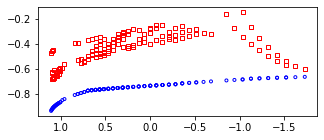

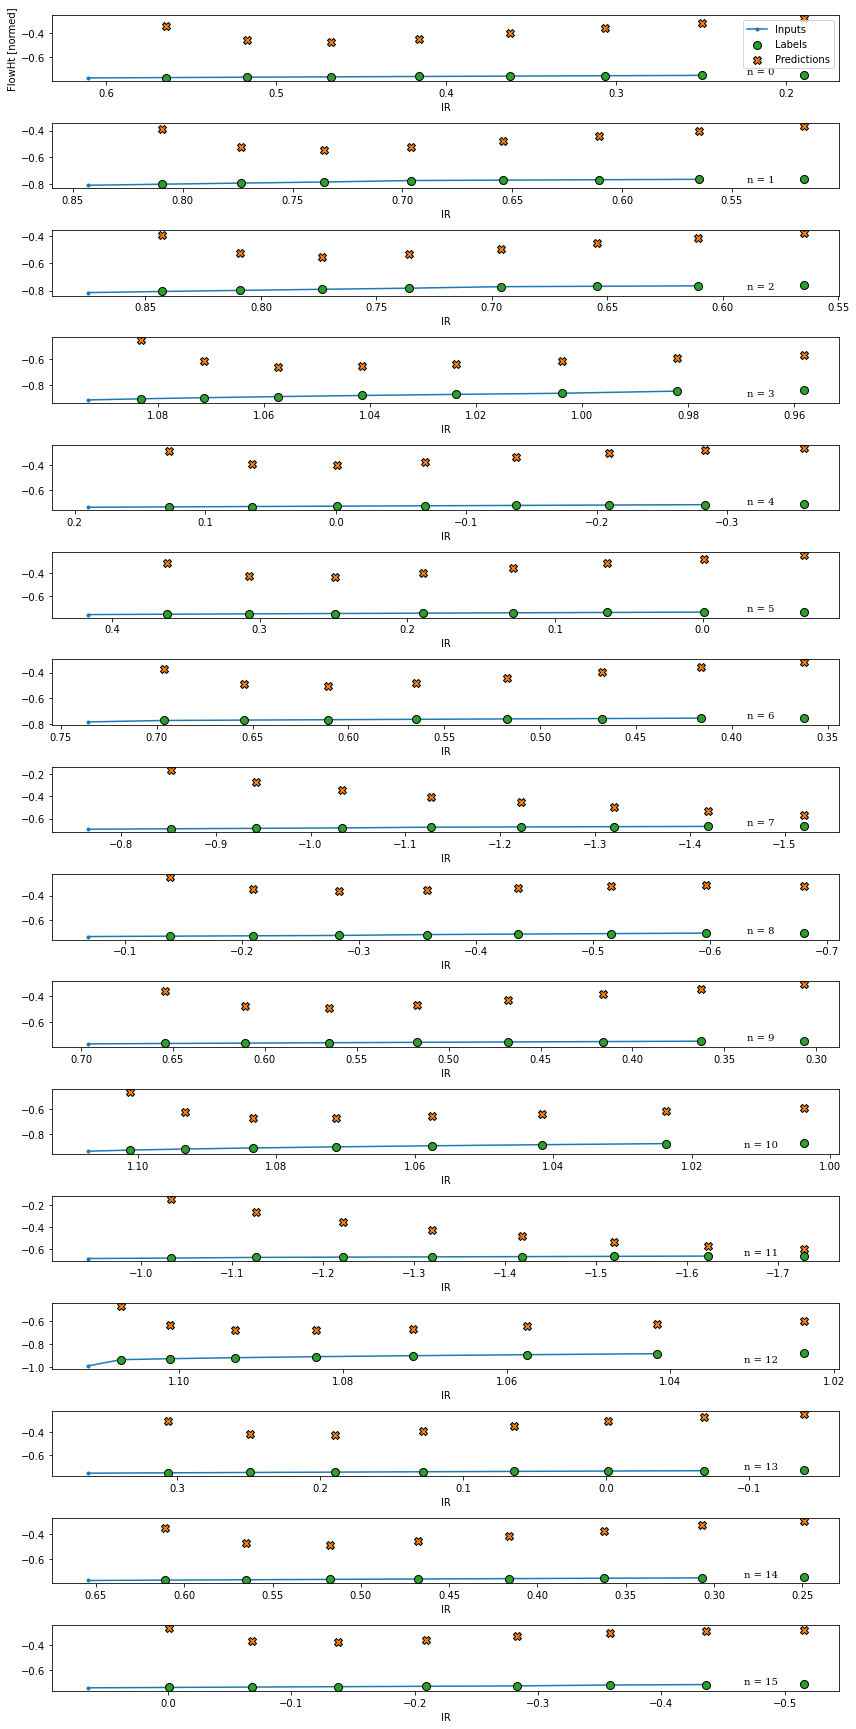

In [103]:
wide_window_t.plot_batch(lstm_model, dset_name= 'test', n_batch =0)

### 성능

이 데이터세트를 사용하면 일반적으로 각 모델의 성능이 이전 모델보다 약간 더 좋습니다.

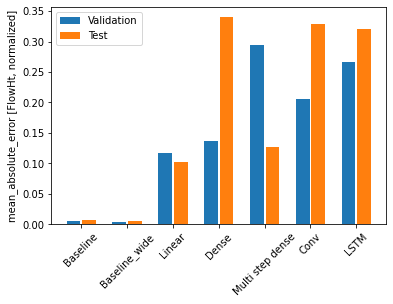

In [104]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [FlowHt, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [73]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0067
Baseline_wide: 0.0055
Linear      : 2.0065
Dense       : 0.0744
Multi step dense: 0.3366
Conv        : 0.3174
LSTM        : 0.2823


##### 다중 출력 모델 -skipped


### Advanced: Residual connections

The Baseline model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next timestep. Similarly, "Residual networks" or "ResNets" in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](https://www.tensorflow.org/tutorials/structured_data/images/residual.png)

Essentially this initializes the model to match the Baseline. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial.

Here it is being applied to the LSTM model, note the use of the tf.initializers.zeros to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the zeros are only used on the last layer.

In [105]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [106]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

his = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()


4/4 [==============================] - 0s 997us/step - loss: 0.4648 - mean_absolute_error: 0.4874

Wall time: 9.84 s


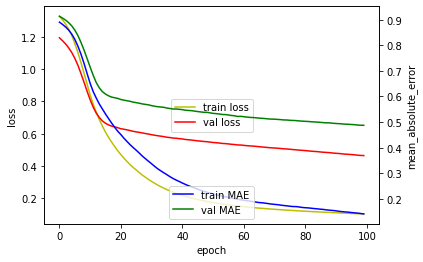

In [107]:
eval(his)

#### 성능

다음은 이러한 다중 출력 모델의 전반적인 성능입니다.

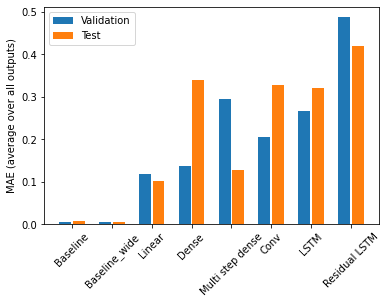

In [108]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [78]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.0067
Baseline_wide  : 0.0055
Linear         : 2.0065
Dense          : 0.0744
Multi step dense: 0.3366
Conv           : 0.3174
LSTM           : 0.2823
Residual LSTM  : 0.4366


위의 성능은 모든 모델 출력에 대한 평균입니다.

## Multi-step models
Both the single-output and multiple-output models in the previous sections made single time step predictions, 1h into the future.

This section looks at how to expand these models to make multiple time step predictions.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

Single shot predictions where the entire time series is predicted at once.
Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.
In this section all the models will predict all the features across all output time steps.

For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24h of the future, given 24h of the past.

Here is a Window object that generates these slices from the dataset:



Total window size: 16
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [ 8  9 10 11 12 13 14 15]
Label column name(s): None

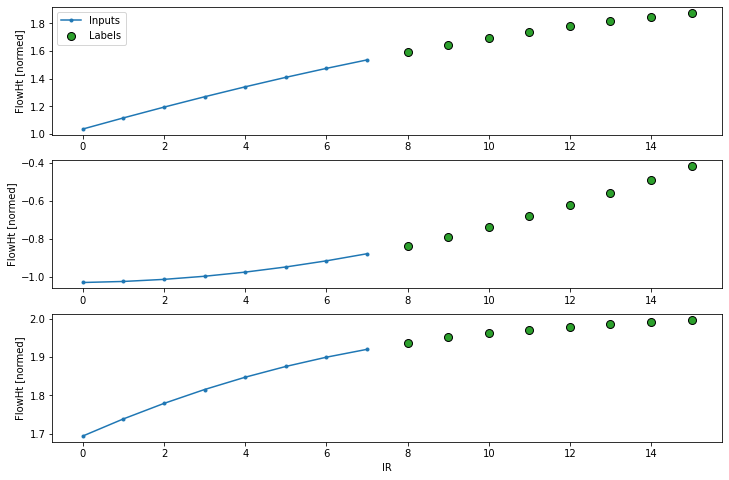

In [79]:
OUT_STEPS = 8
multi_window = WindowGenerator(input_width=8,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)
multi_window.plot()
multi_window


In [80]:
multi_window_t = WinGen(input_width=8,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)
multi_window_t

Total window size: 16
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [ 8  9 10 11 12 13 14 15]
Label column name(s): None

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output timesteps:

![Repeat the last input, for each output step](https://www.tensorflow.org/tutorials/structured_data/images/multistep_last.png)

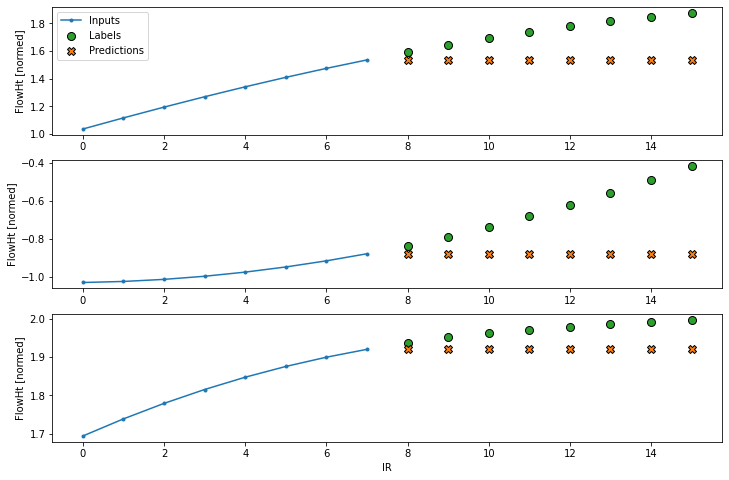

In [81]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])
    # tile the last time step of a batch for the future OUT_STEPS

last_baseline = MultiStepLastBaseline()
#last_baseline.compile(loss=tf.losses.MeanSquaredError(),
#                      metrics=[tf.metrics.MeanAbsoluteError()])
history = compile_and_fit(last_baseline, multi_window)


multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

IPython.display.clear_output()


Since this task is to predict 24h given 24h another simple approach is to repeat the previous day, assuming tomorrow will be similar:
![Repeat the previous day](https://www.tensorflow.org/tutorials/structured_data/images/multistep_repeat.png)

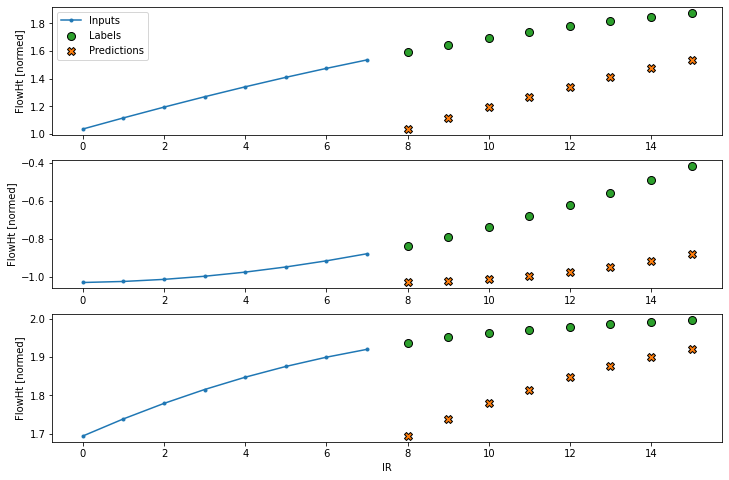

In [82]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
#repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
#                        metrics=[tf.metrics.MeanAbsoluteError()])

history = compile_and_fit(repeat_baseline, multi_window)


multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

IPython.display.clear_output()

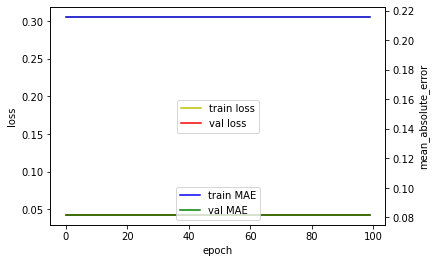

In [83]:
eval(history)

### Single-shot models

One high level approach to this problem is use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `layers.Dense` with `OUT_STEPS*features` output units.
The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline,
but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single
input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predct all timesteps from the last time-step](https://www.tensorflow.org/tutorials/structured_data/images/multistep_dense.png)

3/3 [==============================] - 0s 0s/step - loss: 0.3563 - mean_absolute_error: 0.4737


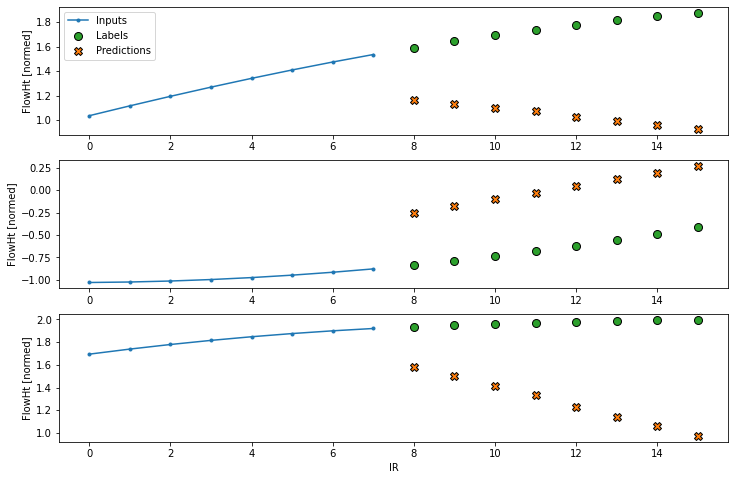

In [84]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

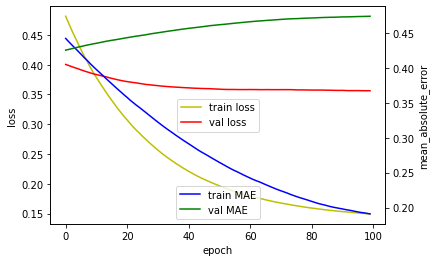

In [85]:
eval(history)


#### Dense

Adding a `layers.Dense` between the input and output gives the linear model more power,
but is still only based on a single input timestep.

3/3 [==============================] - 0s 836us/step - loss: 0.2194 - mean_absolute_error: 0.3173


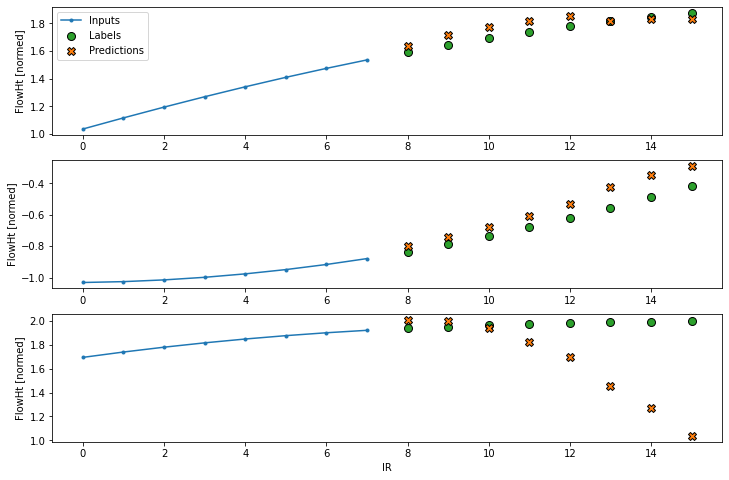

In [86]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)


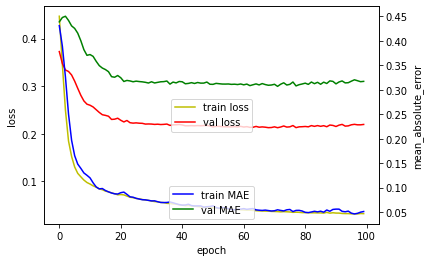

In [87]:
eval(history)

In [109]:
multi_window_t.plot_batch(n_batch=1, model=multi_dense_model,dset_name='train' )

NameError: name 'multi_window_t' is not defined

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than
the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](https://www.tensorflow.org/tutorials/structured_data/images/multistep_conv.png)

3/3 [==============================] - 0s 1ms/step - loss: 0.2386 - mean_absolute_error: 0.3323


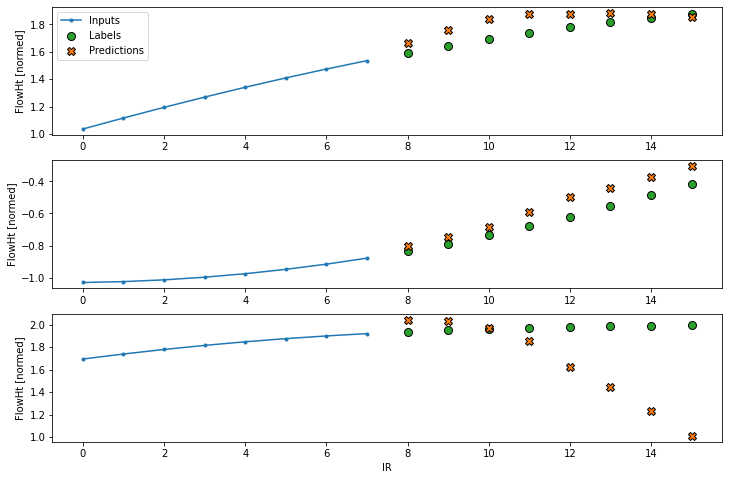

In [89]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

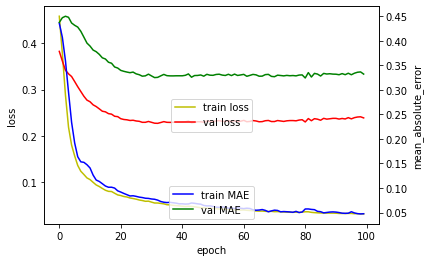

In [90]:
eval(history)

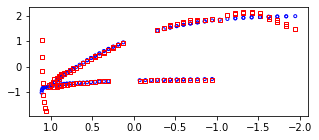

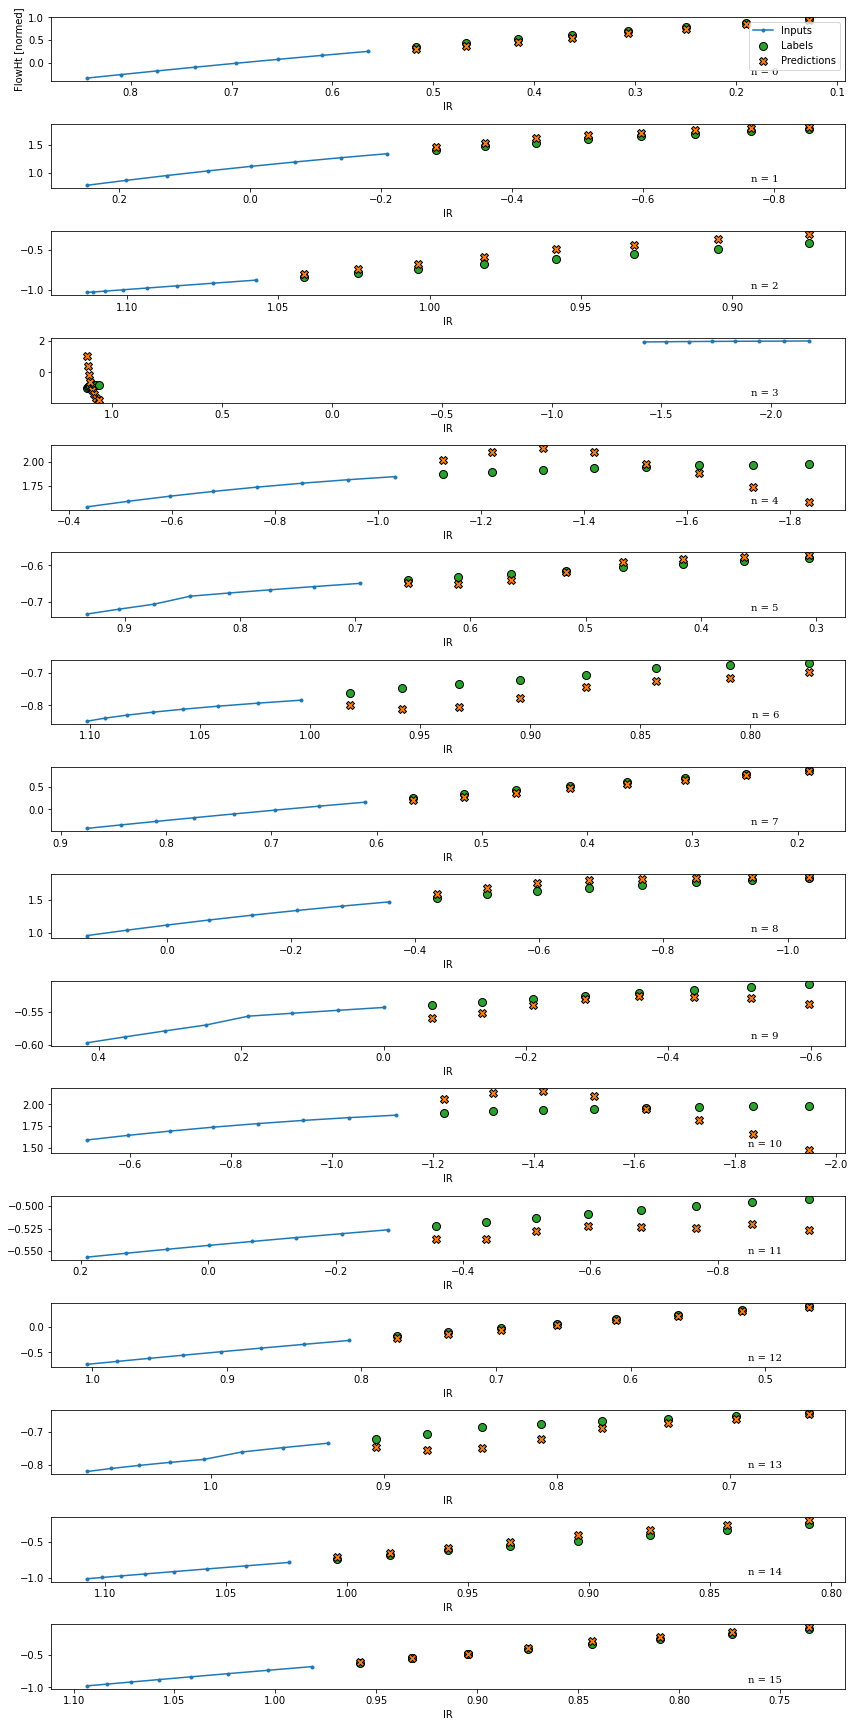

In [91]:
multi_window_t.plot_batch(model=multi_conv_model, n_batch=0, )


#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step,
so set `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](https://www.tensorflow.org/tutorials/structured_data/images/multistep_lstm.png)


3/3 [==============================] - 0s 0s/step - loss: 0.3161 - mean_absolute_error: 0.4498


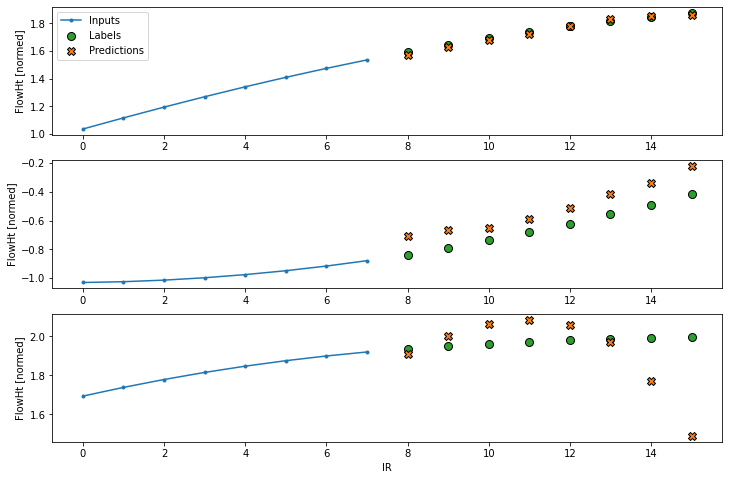

In [92]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

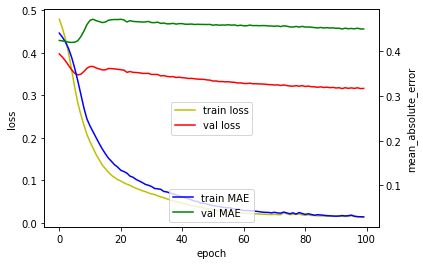

In [93]:
eval(history)

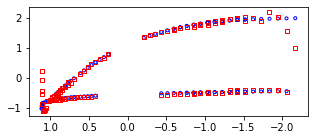

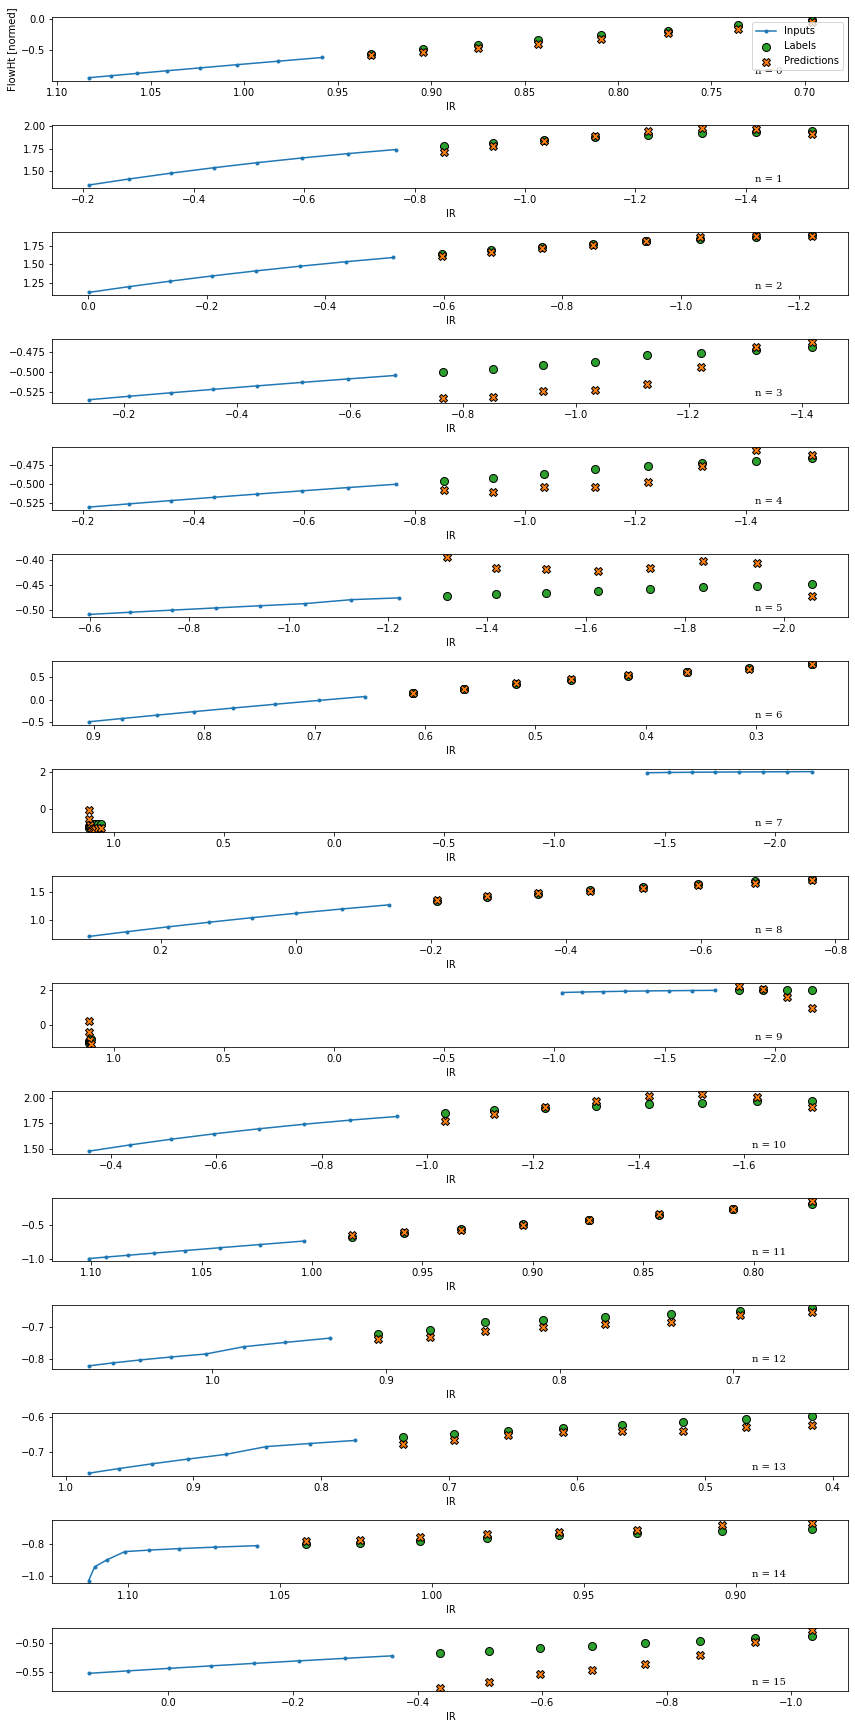

In [94]:
multi_window_t.plot_batch(model=multi_lstm_model, n_batch=0, )

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic Generating Sequences With Recurrent Neural Networks.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](https://www.tensorflow.org/tutorials/structured_data/images/multistep_autoregressive.png)


#### RNN
This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single timestep.

The model will have the same basic form as the single-step LSTM models: An LSTM followed by a layers.Dense that converts the LSTM outputs to model predictions.

A layers.LSTM is a layers.LSTMCell wrapped in the higher level layers.RNN that manages the state and sequence results for you (See Keras RNNs for details).

In this case the model has to manually manage the inputs for each step so it uses layers.LSTMCell directly for the lower level, single time step interface.


이 튜토리얼에서는 자기 회귀 RNN 모델만 빌드하지만 이 패턴은 단일 타임스텝을 출력하도록 설계된 모든 모델에 적용할 수 있습니다.

이 모델은 단일 스텝 `LSTM` 모델과 기본 형태가 동일하여 `LSTM` 다음에 `LSTM` 출력을 모델 예측으로 변환하는 `layers.Dense`가 이어집니다.

`layers.LSTM`은 상태와 시퀀스 결과를 자동으로 관리하는 더 높은 수준의 `layers.RNN`에서 래핑된 `layers.LSTMCell`입니다(자세한 내용은 [Keras RNN](https://www.tensorflow.org/guide/keras/rnn) 참조).

이 경우 모델은 각 스텝에 대한 입력을 수동으로 관리해야 하므로 더 낮은 수준의 단일 타임스텝 인터페이스에 대해 `layers.LSTMCell`를 직접 사용합니다.

In [95]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [96]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

이 모델에 필요한 첫 번째 메서드는 입력을 기반으로 내부 상태를 초기화하는 `warmup` 메서드입니다. 일단 훈련되면 이 상태는 입력 기록의 관련 부분을 캡처합니다. 이는 앞서 알아본 단일 스텝 `LSTM` 모델과 동일합니다.

In [97]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

이 메서드는 단일 타임스텝 예측과 LSTM의 내부 상태를 반환합니다.

In [98]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([16, 6])

`RNN`의 상태 및 초기 예측을 사용하여 이제 이전의 각 스텝에서 수행한 예측을 입력으로 제공하여 모델을 계속 반복할 수 있습니다.

출력 예측을 수집하는 가장 간단한 방법은 Python 목록을 사용하고 루프 후에 `tf.stack`을 사용하는 것입니다.

참고: 이와 같이 Python 목록을 쌓는 것은 훈련을 위해 `Model.compile(..., run_eagerly=True)`를 사용하거나 고정 길이의 출력을 통해 즉시 실행하는 경우에만 효과가 있습니다. 동적 출력 길이의 경우 Python 목록 대신 `tf.TensorArray`를 사용하고 Python `range` 대신 `tf.range`를 사용해야 합니다.

In [99]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

예제 입력에서 이 모델을 테스트 실행합니다.

In [100]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (16, 8, 6)


이제 모델을 훈련합니다.

3/3 [==============================] - 0s 0s/step - loss: 0.3643 - mean_absolute_error: 0.4596


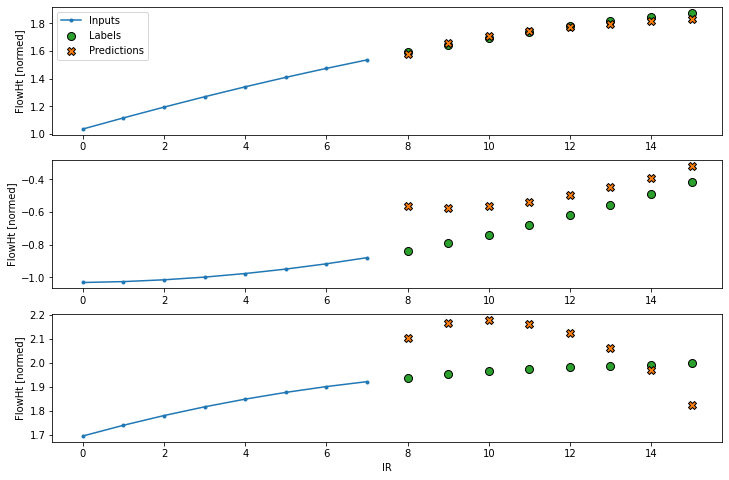

In [101]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### 성능

이 문제에 대해 모델 복잡성이 증가함에 따라 분명히 이득이 감소합니다.

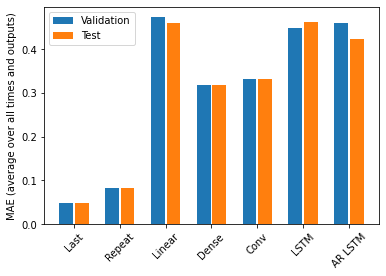

In [102]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

이 튜토리얼의 전반부에서 소개한 다중 출력 모델에 대한 메트릭은 모든 출력 특성에 평균화된 성능을 보여줍니다. 이러한 성능은 유사하지만 출력 타임스텝에서도 평균화됩니다. 

In [103]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.0492
Repeat  : 0.0837
Linear  : 0.4611
Dense   : 0.3173
Conv    : 0.3322
LSTM    : 0.4628
AR LSTM : 0.4231


밀집 모델에서 컨볼루션 및 반복 모델로 이동하여 얻은 이득은 몇 퍼센트(있다고 하더라도)에 불과하며 자기 회귀 모델의 성능은 분명히 더 나빴습니다. 따라서 이러한 더 복잡한 접근 방법은 **이** 문제에서는 가치가 없을 수도 있지만 시도해 보기 전에는 알 수 있는 방법이 없었으며 이러한 모델은 **다른 특정** 문제에 도움이 될 수 있습니다.

## 다음 단계

이 튜토리얼에서는 TensorFlow를 사용한 시계열 예측에 대해 간단히 소개했습니다.

- 자세한 내용은 다음을 참조하세요.
    - [Scikit-Learn, Keras 및 TensorFlow를 이용한 머시러닝 실무](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)(2차 개정 버전), 챕터 15
    - [Python을 이용한 딥러닝](https://www.manning.com/books/deep-learning-with-python) 챕터 6
    - [Udacity의 딥러닝 TensorFlow 개론](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187) 레슨 8 및 [연습 노트북](https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning)
- 또한 TensorFlow에서 [기존의 시계열 모델](https://otexts.com/fpp2/index.html)은 모두 구현할 수 있다는 점을 기억하세요. 이 튜토리얼에서는 TensdorFlow의 내장 기능에 초점을 맞추었습니다.